In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols, wls
from statsmodels.formula.api import mixedlm
from patsy.contrasts import Treatment

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
from statsmodels.discrete.discrete_model import Probit, MNLogit
from statsmodels.tools import add_constant
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFdr
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler



import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(1024)

In [2]:
base_dir = '/home/abhijit/Jyotirmay/my_thesis'
basic_feats = ['age', 'sex', 'bmi_numeric']
normalised_basic_feats = ['age_normalised', 'sex', 'bmi_numeric_normalised']
spleen_sample_cols = ['0_spleen','1_spleen','2_spleen','3_spleen','4_spleen','5_spleen','6_spleen','7_spleen','8_spleen','9_spleen']
liver_sample_cols = ['0_liver','1_liver','2_liver','3_liver','4_liver','5_liver','6_liver','7_liver','8_liver','9_liver']
vols_feat = ['seg_liver', 'seg_spleen']
iou_feats = ['iou_spleen', 'iou_liver', 'iou_mean']
cv_feats = ['cv', 'cvinv']
selected_model_feats = basic_feats + spleen_sample_cols + liver_sample_cols + vols_feat + iou_feats + cv_feats + ['volume_id', 'diabetes_status'] #+ ['iou_dot_seg_spleen_normalised', 'iou_dot_seg_liver_normalised']
selected_dataset_feats = basic_feats +  ['volume_id', 'diabetes_status'] + vols_feat
all_paths = [
#     {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_concat_report_final.csv'},
    {'TRAIN_full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1575638974.364368_concat_report_final.csv'},
    {'TRAIN_hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1575682785.7956946_concat_report_final.csv'},   
    {'TRAIN_MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1575691492.3282661_concat_report_final.csv'},
    {'TRAIN_probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1575685569.8707192_concat_report_final.csv'},
#     {'PPUKB_MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/0_0.0_concat_report_final_pp.csv'},
    {'TEST_full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv'},
    {'TEST_MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv'}, 
    {'TEST_probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_concat_report_final.csv'}, 
    {'TEST_hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv'},
    {'dataset_KORA_processed': './dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv'},
    {'UKB_full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_UKB_v4/UKB/10_1574676555.7948809_concat_report_final_pp_final.csv'},
    {'UKB_MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/0_0.0_concat_report_final_all.csv'},
    {'UKB_probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_UKB_v2/UKB/10_1573834823.1121247_concat_report_final.csv'},
    {'UKB_hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_UKB_v2/UKB/10_1574308007.2486243_concat_report_final.csv'},
    {'dataset_UKB_processed': './dataset_groups/whole_body_datasets/UKB/all_processed_True_concat_report_final.csv'}
]

train_report_paths = [
    {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1575638974.364368_concat_report_final.csv'},
    {'dataset_KORA_processed': './dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv'},
]

ukb_paths = [
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/0_0.0_concat_report_final.csv'},
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_UKB_v2/UKB/10_1573834823.1121247_concat_report_final.csv'}
]

model_report_paths = {key:val for d in all_paths for key,val in d.items()}  #all_paths
# ukb_model_report_paths = {key:val for d in ukb_paths for key,val in d.items()}

In [3]:
flatten = lambda l: [item for sublist in l for item in sublist]

def transform_to_categorical(df, categorical_features_list):
    for f in categorical_features_list:
        dfDummies = pd.get_dummies(df[f], prefix = f)
        df = pd.concat([df, dfDummies], axis=1)
    return df

def rename(df, cols_map=None):
    if cols_map is None:
        cols_map =  {'bmi-numeric':'bmi_numeric', 'blood-pressure-diastolic':'blood_pressure_diastolic', 'blood-pressure-systolic':'blood_pressure_systolic',
             'cholesterol-hdl':'cholesterol_hdl', 'cholesterol-ldl':'cholesterol_ldl', 'cholesterol-total':'cholesterol_total',
             'mri-liver-fat-artifacts':'mri_liver_fat_artifacts', 'mri-liver-fat-lobus-dexter':'mri_liver_fat_lobus_dexter', 
              'mri-liver-fat-lobus-sinister':'mri_liver_fat_lobus_sinister', 'mri-liver-fat-portal-vein':'mri_liver_fat_portal_vein',
             'meds-lipoprotein-lowering':'meds_lipoprotein_lowering', 'meds-antihypertensive':'meds_antihypertensive',
              'smoker_non-smoker':'smoker_non_smoker','alcohol-g/day':'alcohol_g_day'}
    df.rename(columns=cols_map, inplace=True)
    return df

def get_scale_1d(v):
    # I copy this function from R source code haha
    v = v[~np.isnan(v)]
    std = np.sqrt(
        np.sum(v ** 2) / np.max([1, len(v) - 1])
    )
    return std



def z_score_column_normalise(df, column_list):
    normalised_cols_map = {}
    for column in column_list:
        normalised_cols_map[column] = column+'_normalised'
#         sc = StandardScaler()
#         data = df[column].values.reshape(-1, 1)
#         sc.fit(data)
#         sc.std_ = np.apply_along_axis(func1d=get_scale_1d, axis=0, arr=data)
#         df[normalised_cols_map[column]] = sc.transform(data)
#         df[normalised_cols_map[column]] = (df[column] - df[column].mean())/df[column].std(ddof=1)
        df[normalised_cols_map[column]] = (df[column] - df[column].min())/ (df[column].max() - df[column].min())
    return df, normalised_cols_map

def z_score_group_normalise(df, cols_to_normalise):
    normalised_cols_map = {}
    group_cols_value = df[cols_to_normalise].values
    mean, std = np.mean(group_cols_value), np.std(group_cols_value, ddof=0)
    for column in cols_to_normalise:
        normalised_cols_map[column] = 'normalised_'+column
        df[normalised_cols_map[column]] = (df[column] - mean)/std
    return df, normalised_cols_map

def pre_process_for_mlm(df, to_be_transpose_cols, value_name):
    cols = list(df.columns)
    cols_without_tobe_transposed_cols = list(set(cols) - set(to_be_transpose_cols))
    df = df.melt(id_vars=cols_without_tobe_transposed_cols, 
            value_vars=to_be_transpose_cols, 
            value_name=value_name)

    return df

def model_evaluation_matrics(file_paths_dict, cols_to_fetch):
    dicts = {}
    for model, path in file_paths_dict.items():
        if 'dataset' in model:
            continue
        df = pd.read_csv(path)
        dicts[model] = df[cols_to_fetch].iloc[1:].mean()
    return dicts

def individual_feature_stats(feats, df, target_col, categorical_feats=['diabetes_status', 'sex']):
    p_values = {}
    for f in feats:
        try:
            features_string = make_feature_string([f], categorical_feats)
            fii = ols(f'{target_col} ~ {features_string}', df).fit()
            feat_dict = fii.pvalues.to_dict()
            coeffs = fii.params
        
            for k, v in feat_dict.items():
                orig_key = k
                if k == 'Intercept':
                    k = f+'_Intercept'
                p_values[k] = v

                p_values[k+'_coeff'] = coeffs[orig_key]
            p_values['fitting_score'] = fii.rsquared
        except Exception as e:
            print(e)

    return p_values


def make_feature_string(feats, categorical_cols=[]):
    feat_str = '1+'
    for c_col in categorical_cols:
        if type(c_col) is tuple:
            if c_col[0] not in feats:
#                 print(f'{c_col} is not present in given feature list, SKIPPING IT!')
                continue
            feat_str += f'C({c_col[0]}, Treatment(reference={c_col[1]}))+'
            c_col = c_col[0]
        else:
            if c_col not in feats:
#                 print(f'{c_col} is not present in given feature list, SKIPPING IT!')
                continue
            feat_str += f'C({c_col}, Treatment)+'
        feats.remove(c_col)
    
    other_feats_str = '+'.join(feats)
    if other_feats_str is '':
        final_feat_str = feat_str[:-1]
    else:
        final_feat_str = feat_str + other_feats_str

    return final_feat_str
    
def normal_mixed_effect_model(df, target_col, features_string, group_col, L1_wt=None):
    if L1_wt is None:
        model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit()
    else:
        model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit_regularized(L1_wt=L1_wt)
    return model

def anova_test(ols_model):
    anova_stats = sm.stats.anova_lm(ols_model)
    return anova_stats

def df_from_nested_dicts(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv, index=[0]).T}, axis=1) for k, v in dicts.items() for kk, vv in v.items()}, axis=1)
    return df

def df_from_nested_dicts_group(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv, index=[0]).T}, axis=1) for k, v in dicts.items() for kk, vv in v.items()}, axis=1)
    return df

def highlight_significance(df, threshold=0.05):
    return df.style.applymap(lambda x: 'background-color : yellow' if x==True or x<threshold else '')


def discrete_group_feature_stats(feats, df, target_col, categorical_feats=['diabetes_status', 'sex'], 
                                 is_classification=False, l1mp=0.01):
    p_values = {}
#     try:
#             features_string = f'1+C({f}, Treatment)' if f in categorical_feats else f'1+{f}'
#         df['bmi_2'] = df['bmi_numeric'] ** 2
#         feats = feats + ['bmi_2']
    x = df[feats]
    y = df[target_col]

    x = add_constant(x)
    model = Probit(y, x)
    fii = model.fit_regularized(alpha=l1mp)
    predicted = fii.predict(x)
    feat_dict = fii.pvalues.to_dict()
    coeffs = fii.params

    for k, v in feat_dict.items():
        p_values[k] = v
        p_values[k+'_coeff'] = coeffs[k]

    p_values['aic'] = fii.aic
    p_values['bic'] = fii.bic
    p_values['psuedo_r2'] = fii.prsquared
#     except Exception as e:
#         print('ERROR:', e)

    return p_values, fii, (y, predicted)

# def weighted_group_feats(df, target_col, features_string, alpha_col):
#     alpha = df[alpha_col].values
#     model = wls(f'{target_col} ~ {features_string}', df, weights=(1/(1-alpha))).fit()
#     return model

def discrete_weighted_group_feats(df, target_col, feats, alpha_col, l1mp=0.01):
    p_values = {}
    alpha = df[alpha_col].values
#     df['bmi_2'] = df['bmi_numeric'] ** 2
#     feats = feats + ['bmi_2']
    x = df[feats]
    y = df[target_col]
    
    x = add_constant(x)
    fii = sm.GLM(y, x, family=sm.families.Binomial(sm.families.links.probit), var_weights=alpha).fit_regularized(alpha=l1mp)
    predicted = fii.predict(x)
#     feat_dict = fii.pvalues.to_dict()
#     coeffs = fii.params

#     for k, v in feat_dict.items():
#         p_values[k] = v
#         p_values[k+'_coeff'] = coeffs[k]

#     p_values['aic'] = fii.aic
#     p_values['bic'] = fii.bic
#     sst_val = sum(map(lambda x: np.power(x,2),y-np.mean(y))) 
#     sse_val = sum(map(lambda x: np.power(x,2),fii.resid_response)) 
#     r2 = 1-(sse_val/sst_val)
#     p_values['psuedo_r2'] = r2
    return p_values, fii, (y, predicted)

def normal_group_fit(df, target_col, features_string):
    p_values = {}
    fii = ols(f'{target_col} ~ {features_string}', df).fit()
    y = df[target_col].values
    predicted = fii.predict(df)
    feat_dict = fii.pvalues.to_dict()
    coeffs = fii.params

    for k, v in feat_dict.items():
        p_values[k] = v
        p_values[k+'_coeff'] = coeffs[k]

    p_values['aic'] = fii.aic
    p_values['bic'] = fii.bic
    p_values['psuedo_r2'] = fii.rsquared
    return p_values, fii, (y, predicted)

def weighted_group_feats(df, target_col, features_string, alpha_col):
    p_values = {}
    alpha = df[alpha_col].values
    fii = wls(f'{target_col} ~ {features_string}', df, weights=alpha).fit()
    y = df[target_col].values
    predicted = fii.predict(df)
    feat_dict = fii.pvalues.to_dict()
    coeffs = fii.params
    
    for k, v in feat_dict.items():
        p_values[k] = v
        p_values[k+'_coeff'] = coeffs[k]

    p_values['aic'] = fii.aic
    p_values['bic'] = fii.bic
    p_values['psuedo_r2'] = fii.rsquared
    return p_values, fii, (y, predicted)

In [4]:
def normalise_iou(df):
    for iou_col in ['iou_spleen', 'iou_liver', 'iou_mean']:
        iou = df[iou_col]
#         iou = (iou - iou.mean())/iou.std(ddof=0)
        iou = (iou - iou.min()) / (iou.max() - iou.min())
        df[f'{iou_col}_normalised'] = iou
#     df['iou_mean_normalised'] = (df['iou_spleen_normalised'] + df['iou_liver_normalised']) / 2
    return df

In [5]:
def plot_pdf(good_pdf, bad_pdf, ax):
    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    ax.set_xlim([0,1])
    ax.set_ylim([0,5])
    ax.set_title("Probability Distribution", fontsize=14)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlabel('P(X="bad")', fontsize=12)
    ax.legend(["good","bad"])

def auc_roc(y_yp, title):
    y, predicted = y_yp
    y_p = np.where(predicted > 0.5, 1, 0)
    labels = [0, 1]
    y_1_mask = np.where(y==1, True, False)
    y_0_mask = np.where(y==0, True, False)
    xs = [predicted[y_0_mask], predicted[y_1_mask]]

    fig, ax0 = plt.subplots(nrows=1, ncols=1)
    colors = ['red','blue']
    ax0.hist(xs, 10, normed=1, histtype='bar', color=colors, label=labels)
    ax0.legend(prop={'size': 10})
    ax0.set_title('bars with legend')
    plt.show()
    
   
    fpr, tpr, thresholds = metrics.roc_curve(y, predicted, pos_label=1)
    auc_score = metrics.roc_auc_score(y, predicted)
 
#     f1_score = metrics.f1_score(y, y_p, labels=labels)
    print(f'{title}: auc_score: {auc_score}')
#     plt.scatter(predicted, y)
#     plt.show()
    plt.plot(fpr, tpr)
    plt.show()
#     print(list(y))
#     print(predicted)
    
#     print(y_p)
    
    cm = confusion_matrix(y, y_p, labels)
    print(cm)
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(cm)
#     plt.title('Confusion matrix of the classifier')
#     fig.colorbar(cax)
#     ax.set_xticklabels([''] + labels)
#     ax.set_yticklabels([''] + labels)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()
    
#     unique_elements, counts_elements = np.unique(predicted, return_counts=True)
#     plt.hist(predicted, bins=20)
#     plt.bar(unique_elements, counts_elements)
#     plt.show()
    
#     print(disp)
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)
#     print(f'{title}:::  fpr: {fpr}, tpr: {tpr}, threshold: {thresholds}')
    return auc_score, 1

def regression_plot(y_yp, title=''):
    y, predicted = y_yp
    print(title)
    plt.scatter(predicted, y)
    plt.show()
    
def random_forest_evaluations(df, target_col, feats):
    y = df[target_col]
    x = df[feats]
    kfold_rf = model_selection.KFold(n_splits=10, random_state=10)
    model_rf = RandomForestClassifier(n_estimators=100, max_features=3)
    results_rf = model_selection.cross_val_score(model_rf, x, y, cv=kfold_rf)
    print('Random Forest Out:', results_rf.mean())
    return results_rf.mean()

def gradient_boosting_evaluations(feats, df, target_col, categorical_feats=['diabetes_status', 'sex'], 
                                 is_classification=False, l1mp=0.01):
    y = df[target_col]
    x = df[feats]
    x = add_constant(x)
    
    kfold_rf = model_selection.KFold(n_splits=10, random_state=10)
    model_rf = GradientBoostingClassifier(n_estimators=100, random_state=10)
    results_rf = model_selection.cross_val_score(model_rf, x, y, cv=kfold_rf)
    print('Gradient Boosting Out:', results_rf.mean())
    model_gb_fitted = model_rf.fit(x, y)
    y_p = model_gb_fitted.predict(x)
    auc, _ = auc_roc((y, y_p), 'ensemble')
    
    return {'aic': auc}, model_gb_fitted, (y, y_p)

def weighted_gradient_boosting_evaluations(df, target_col, feats, alpha_col, l1mp=0.01):
    y = df[target_col]
    x = df[feats]
    x = add_constant(x)
    
    alpha = df[alpha_col].values
    
    kfold_rf = model_selection.KFold(n_splits=10, random_state=10)
    model_rf = GradientBoostingClassifier(n_estimators=100, random_state=10)
    results_rf = model_selection.cross_val_score(model_rf, x, y, cv=kfold_rf)
    print('Gradient Boosting Out:', results_rf.mean())
    model_gb_fitted = model_rf.fit(x, y, sample_weight=alpha)
    y_p = model_gb_fitted.predict(x)
    auc, _ = auc_roc((y, y_p), 'ensemble')
    
    return {'aic': auc}, model_gb_fitted, (y, y_p)

def bagging_evaluations(df, target_col, feats):
    y = df[target_col]
    x = df[feats]
    kfold = model_selection.KFold(n_splits=10, random_state=10)
    model_1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=10)
    results_1 = model_selection.cross_val_score(model_1, x, y, cv=kfold)
    print('Bagging Out:', results_1.mean())
    return results_1.mean()

def sgd_evaluator(df, target_col, feats):
    y = df[target_col]
    x = df[feats]
    kfold_sgb = model_selection.KFold(n_splits=10, random_state=10)
    model_sgb = GradientBoostingClassifier(n_estimators=100, random_state=10)
    results_sgb = model_selection.cross_val_score(model_sgb, x, y, cv=kfold_sgb)
    
    y_p = model_sgb.fit(x, y).predict(x)
    print('model score: ', model_sgb.score(x, y))
    auc_roc((y, y_p), 'sgd')
    print('Stochastic Gradient out:', results_sgb)
    
    
    
    
    return results_sgb.mean()

def voting_classifier_evaluator(df, target_col, feats, weight_col=None, ensemble=None):
    y = df[target_col]
#     feats = ['age', 'bmi_numeric']
    if weight_col is None:
        x = df[feats]
        weights = None
    else:
        x = df[feats]
        weights = df[weight_col].values
    
    x = add_constant(x)
    
    X_train, X_test, y_train, y_test = x, x, y, y #train_test_split(x, y, test_size=0.33, random_state=10)

   
    if ensemble is None:
        estimators = []
    
#         mod_rf = RandomForestClassifier(n_estimators=100, max_features=3)
#         estimators.append(('rf', mod_rf))
        mod_bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=10)
        estimators.append(('bagging', mod_bagging))
        mod_sgd = GradientBoostingClassifier(n_estimators=100, random_state=10)
        estimators.append(('sgd', mod_sgd))
        mod_lr = LogisticRegression()
        estimators.append(('logistic', mod_lr))
        mod_dt = DecisionTreeClassifier()
        estimators.append(('cart', mod_dt))
        mod_sv = SVC()
        estimators.append(('svm', mod_sv))
      
        ensemble = VotingClassifier(estimators)
#         print(X_train.columns)
        ensemble.fit(X_train, y_train, sample_weight=weights)
    else:
       
        X_train, X_test, y_train, y_test = x, x, y, y
    
#     fig, axes = plt.subplots(1, 1, figsize=(14, 6))
#     if weights is None:
#         weights = np.ones(len(X_train))
#     plot_decision_function(ensemble, weights, axes, title, X_train.values, y_train.values)
#     print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print(ensemble)
#     auc_roc((y_train, ensemble.predict(X_train)), 'ensemble')
#     print('ensemble score train set: ',ensemble.score(X_train, y_train))

    auc, _ = auc_roc((y_test, ensemble.predict(X_test)), 'ensemble')
#     print('ensemble score test set: ',ensemble.score(X_test, y_test))
#      kfold_vc = model_selection.KFold(n_splits=10, random_state=10)
#     results_vc = model_selection.cross_val_score(ensemble, X_test, y_test, cv=kfold_vc)
#     print('Voting Classifier out many mean:', results_vc.mean())
# 
    return 1, 1, ensemble, auc

def plot_decision_function(classifier, sample_weight, axis, title, X, y):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], X[:, 1], c=y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black')

    axis.axis('off')
    axis.set_title(title)
    
def aggregate_model_outputs(df, target_col, feats, dicts, model, key, ensemble_model=None, weight_col=None):
#     dicts['rf'] = random_forest_evaluations(df, target_col, feats)
#     dicts[model][key]['bagging'] = bagging_evaluations(df, target_col, feats)
#     dicts[model][key]['sgd'] = sgd_evaluator(df, target_col, feats)
#     df['bmi_2'] = df['bmi_numeric'] **2
#     feats = feats + ['bmi_2']
    dicts[model][key]['v_scoring'],dicts[model][key]['v_scoring_with_weight'], ensemble_model, dicts[model][key]['v_auc'] = voting_classifier_evaluator(df, target_col, feats, weight_col, ensemble_model)
    
    return dicts, ensemble_model

def calculate_cv_and_cvinv(df):
    df['cv'] = df[liver_sample_cols].std(axis=1, ddof=1) / df[liver_sample_cols].mean(axis=1)
    df['cvinv'] = 1/df['cv']
    return df

In [6]:
cols_to_fetch = ['sncc', 'ged', 'iou_spleen', 'iou_liver', 'dice_spleen',
       'dice_liver', 'surface_distance_avg_spleen', 'surface_distance_avg_liver']
dicts = model_evaluation_matrics(model_report_paths, cols_to_fetch)
df_model_eval = pd.DataFrame.from_dict(dicts)
df_model_eval = df_model_eval.T
# df_model_eval.columns = cols_to_fetch
df_model_eval

,sncc,ged,iou_spleen,iou_liver,dice_spleen,dice_liver,surface_distance_avg_spleen,surface_distance_avg_liver
TRAIN_full_bayesian_0dot01,0.416059,0.155863,0.847247,0.877531,0.913438,0.939127,0.938857,0.866480
TRAIN_hierarchical_quicknat,0.254787,0.142976,0.991133,0.992448,0.930222,0.952808,0.966050,0.928719
TRAIN_MC_dropout_quicknat,0.451659,0.121835,0.878469,0.903837,0.931591,0.955732,0.969341,0.940351
TRAIN_probabilistic_quicknat,0.222936,0.136543,0.992391,0.994402,0.936553,0.953047,0.975707,0.929685
TEST_full_bayesian_0dot01,0.440058,0.195726,0.778430,0.843838,0.876213,0.921414,0.878335,0.817338
TEST_MC_dropout_quicknat,0.400336,0.166126,0.821658,0.878743,0.897251,0.937764,0.915783,0.871014
TEST_probabilistic_quicknat,0.164762,0.228213,0.988126,0.992441,0.873734,0.925382,0.875181,0.827286
TEST_hierarchical_quicknat,0.188499,0.209206,0.983803,0.989027,0.883031,0.932817,0.897130,0.854920
UKB_full_bayesian_0dot01,NaN,NaN,0.683044,0.746261,NaN,NaN,NaN,NaN
UKB_MC_dropout_quicknat,NaN,NaN,0.707228,0.777343,NaN,NaN,NaN,NaN


In [7]:
df_model_eval[['dice_spleen', 'dice_liver']].mean(axis=1)

TRAIN_full_bayesian_0dot01      0.926283
TRAIN_hierarchical_quicknat     0.941515
TRAIN_MC_dropout_quicknat       0.943662
TRAIN_probabilistic_quicknat    0.944800
TEST_full_bayesian_0dot01       0.898814
TEST_MC_dropout_quicknat        0.917508
TEST_probabilistic_quicknat     0.899558
TEST_hierarchical_quicknat      0.907924
UKB_full_bayesian_0dot01             NaN
UKB_MC_dropout_quicknat              NaN
UKB_probabilistic_quicknat           NaN
UKB_hierarchical_quicknat            NaN
dtype: float64

# Post Process reports

In [8]:
dfs_train = {}
common_vols = None

for model, path in model_report_paths.items():
    if 'dataset' in model:
        continue
    if 'TRAIN' not in model:
        continue
    print(model)
    df = pd.read_csv(path)
    
    df = calculate_cv_and_cvinv(df)
    
    df = rename(df)
    
    dfs_train[model] = df
    vols = df[(df['iou_liver']>0.51) & (df['iou_liver'] != 1.0)].volume_id.values
    if common_vols is None:
        common_vols = vols
    else:
        common_vols = np.intersect1d(common_vols, vols)
    print(common_vols.shape)

df_dataset = pd.read_csv(model_report_paths['dataset_KORA_processed'])
df_dataset = rename(df_dataset)
dfs_train['dataset_KORA_processed']  = df_dataset

for model, df in dfs_train.items():
    if 'dataset' in model:
        selected_feats = selected_dataset_feats
    else:
        selected_feats = selected_model_feats #+ ['iou_spleen_normalised', 'iou_liver_normalised', 'iou_mean_normalised']
     
        
    df = df[df.volume_id.isin(common_vols)][selected_feats]
    df['seg_spleen_bmi_normalised'] = df['seg_spleen'] / df['bmi_numeric']
    df['seg_liver_bmi_normalised'] = df['seg_liver'] / df['bmi_numeric']
    df['age2'] = df['age'] ** 2
    df['bmi2'] = df['bmi_numeric'] ** 2
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver', 'age', 'bmi_numeric','seg_liver_bmi_normalised', 'seg_spleen_bmi_normalised'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen_bmi_normalised', 'seg_liver_bmi_normalised'])
    if 'dataset' not in model:
        df['iou_dot_seg_spleen'] = df['iou_spleen'] * df['seg_spleen']
        df['iou_dot_seg_liver'] = df['iou_liver'] * df['seg_liver']
        df, _ =  z_score_column_normalise(df, ['iou_dot_seg_spleen', 'iou_dot_seg_liver'])
        df = normalise_iou(df)
#         print(df[])
    dfs_train[model] = df
    print('model shape:', dfs_train[model].shape)

## Change pre-diabetic state to diabetic
for model, df in dfs_train.items():
    df.loc[df['diabetes_status']==2, 'diabetes_status'] = 1
    dfs_train[model] = df
    dfs_train[model].to_csv(f'final_feats_TRAIN_{model}.csv', index=False)

print(dfs_train.keys())

TRAIN_full_bayesian_0dot01
(155,)
TRAIN_hierarchical_quicknat
(155,)
TRAIN_MC_dropout_quicknat
(155,)
TRAIN_probabilistic_quicknat
(155,)
model shape: (155, 49)
model shape: (155, 49)
model shape: (155, 49)
model shape: (155, 49)
model shape: (155, 17)
dict_keys(['TRAIN_full_bayesian_0dot01', 'TRAIN_hierarchical_quicknat', 'TRAIN_MC_dropout_quicknat', 'TRAIN_probabilistic_quicknat', 'dataset_KORA_processed'])


In [9]:
dfs = {}
common_vols = None

for model, path in model_report_paths.items():
    if 'dataset' in model:
        continue
    if 'TEST' not in model:
        continue
    print(model)
    df = pd.read_csv(path)
    
    df = calculate_cv_and_cvinv(df)
        
    df = rename(df)
    dfs[model] = df
    vols = df[(df['iou_liver']>0.51) & (df['iou_liver'] != 1.0)].volume_id.values
    if common_vols is None:
        common_vols = vols
    else:
        common_vols = np.intersect1d(common_vols, vols)
    print(common_vols.shape)

df_dataset = pd.read_csv(model_report_paths['dataset_KORA_processed'])
df_dataset = rename(df_dataset)
dfs['dataset_KORA_processed']  = df_dataset

for model, df in dfs.items():
    if 'dataset' in model:
        selected_feats = selected_dataset_feats
    else:
        selected_feats = selected_model_feats #+ ['iou_spleen_normalised', 'iou_liver_normalised', 'iou_mean_normalised']
     
        
    df = df[df.volume_id.isin(common_vols)][selected_feats]
    df['seg_spleen_bmi_normalised'] = df['seg_spleen'] / df['bmi_numeric']
    df['seg_liver_bmi_normalised'] = df['seg_liver'] / df['bmi_numeric']
    df['age2'] = df['age'] ** 2
    df['bmi2'] = df['bmi_numeric'] ** 2
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver', 'age', 'bmi_numeric','seg_liver_bmi_normalised', 'seg_spleen_bmi_normalised'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen_bmi_normalised', 'seg_liver_bmi_normalised'])
    if 'dataset' not in model:
        df['iou_dot_seg_spleen'] = df['iou_spleen'] * df['seg_spleen']
        df['iou_dot_seg_liver'] = df['iou_liver'] * df['seg_liver']
        df, _ =  z_score_column_normalise(df, ['iou_dot_seg_spleen', 'iou_dot_seg_liver'])
        df = normalise_iou(df)
#         print(df[])
    dfs[model] = df
    print('model shape:', dfs[model].shape)

## Change pre-diabetic state to diabetic
for model, df in dfs.items():
    df.loc[df['diabetes_status']==2, 'diabetes_status'] = 1
    dfs[model] = df
    dfs[model].to_csv(f'final_feats_TEST_{model}.csv', index=False)
    
print(dfs.keys())

TEST_full_bayesian_0dot01
(150,)
TEST_MC_dropout_quicknat
(150,)
TEST_probabilistic_quicknat
(150,)
TEST_hierarchical_quicknat
(150,)
model shape: (150, 49)
model shape: (150, 49)
model shape: (150, 49)
model shape: (150, 49)
model shape: (150, 17)
dict_keys(['TEST_full_bayesian_0dot01', 'TEST_MC_dropout_quicknat', 'TEST_probabilistic_quicknat', 'TEST_hierarchical_quicknat', 'dataset_KORA_processed'])


In [10]:
dfs_ukb = {}
common_vols = None

for model, path in model_report_paths.items():
    if 'dataset' in model:
        continue
    if 'UKB' not in model:
        continue
    print(model)
    df = pd.read_csv(path)
    
    df = calculate_cv_and_cvinv(df)
        
    df = rename(df)
    df = df.fillna(0)
    df.drop_duplicates(subset ="volume_id", inplace = True)
    dfs_ukb[model] = df
    vols = df[(df['iou_liver']>0.51) & (df['iou_liver'] != 1.0)].volume_id.values
    if common_vols is None:
        common_vols = vols
    else:
        common_vols = np.intersect1d(common_vols, vols)
    print(common_vols.shape)

df_dataset = pd.read_csv(model_report_paths['dataset_UKB_processed'])

# common_vols = np.intersect1d(common_vols, df_dataset.volume_id.values)
df_dataset = rename(df_dataset)

dfs_ukb['dataset_UKB_processed']  = df_dataset

for model, df in dfs_ukb.items():
    if 'dataset' in model:
        selected_feats = selected_dataset_feats
        df = df[selected_feats]
    else:
        selected_feats = selected_model_feats #+ ['iou_spleen_normalised', 'iou_liver_normalised', 'iou_mean_normalised']
        df = df[df.volume_id.isin(common_vols)][selected_feats]
        
    df['seg_spleen_bmi_normalised'] = df['seg_spleen'] / df['bmi_numeric']
    df['seg_liver_bmi_normalised'] = df['seg_liver'] / df['bmi_numeric']
    df['age2'] = df['age'] ** 2
    df['bmi2'] = df['bmi_numeric'] ** 2
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver', 'age', 'bmi_numeric'])
    df, normalised_cols = z_score_column_normalise(df, ['seg_spleen_bmi_normalised', 'seg_liver_bmi_normalised'])
    if 'dataset' not in model:
        df['iou_dot_seg_spleen'] = df['iou_spleen'] * df['seg_spleen']
        df['iou_dot_seg_liver'] = df['iou_liver'] * df['seg_liver']
        df, _ =  z_score_column_normalise(df, ['iou_dot_seg_spleen', 'iou_dot_seg_liver'])
        df = normalise_iou(df)
    dfs_ukb[model] = df
    print(f'model shape of {model}:', dfs_ukb[model].shape)
    print(dfs_ukb[model].columns)
# df_dataset = pd.read_csv(model_report_paths['dataset_KORA_processed'])
# df_dataset = rename(df_dataset)
# dfs['dataset_KORA_processed'] = df[df.volume_id.isin(common_vols)][selected_dataset_feats]
# print(dfs['dataset_KORA_processed'].shape)

## Change pre-diabetic state to diabetic
for model, df in dfs_ukb.items():
    df.loc[df['diabetes_status']==2, 'diabetes_status'] = 1
    dfs_ukb[model] = df
    dfs_ukb[model].to_csv(f'final_feats_UKB_{model}.csv', index=False)
    
print(dfs_ukb.keys())

UKB_full_bayesian_0dot01
(14698,)
UKB_MC_dropout_quicknat
(13987,)
UKB_probabilistic_quicknat
(13984,)
UKB_hierarchical_quicknat
(13970,)
model shape of UKB_full_bayesian_0dot01: (13970, 49)
Index(['age', 'sex', 'bmi_numeric', '0_spleen', '1_spleen', '2_spleen',
       '3_spleen', '4_spleen', '5_spleen', '6_spleen', '7_spleen', '8_spleen',
       '9_spleen', '0_liver', '1_liver', '2_liver', '3_liver', '4_liver',
       '5_liver', '6_liver', '7_liver', '8_liver', '9_liver', 'seg_liver',
       'seg_spleen', 'iou_spleen', 'iou_liver', 'iou_mean', 'cv', 'cvinv',
       'volume_id', 'diabetes_status', 'seg_spleen_bmi_normalised',
       'seg_liver_bmi_normalised', 'age2', 'bmi2', 'seg_spleen_normalised',
       'seg_liver_normalised', 'age_normalised', 'bmi_numeric_normalised',
       'seg_spleen_bmi_normalised_normalised',
       'seg_liver_bmi_normalised_normalised', 'iou_dot_seg_spleen',
       'iou_dot_seg_liver', 'iou_dot_seg_spleen_normalised',
       'iou_dot_seg_liver_normalised', 

# Equations

Eq-1: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI

Eq-2: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI + a4*seg_<spleen|liver>

Eq-3: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI + a4*seg_<spleen|liver> + a5*iou_<spleen|liver>

Eq-4: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI + a4*(iou_<spleen|liver> * seg_<spleen|liver>)

Eq-4: (Diabetes_status == a0 +a1*age + a2*sex + a3*BMI + a4*seg_<spleen|liver>) * iou_<spleen|liver>

// Eq-5: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI +  a4*seg_<spleen|liver>)i

# Group features (eq 1, eq 2, eq 3 and eq 4)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4708530529337158
            Iterations: 50
            Function evaluations: 56
            Gradient evaluations: 50


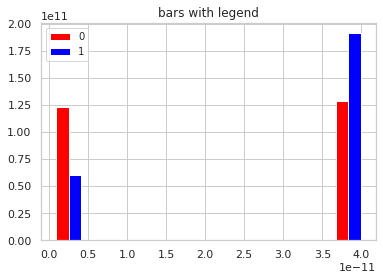

TEST_full_bayesian_0dot01_csv_features: auc_score: 0.625


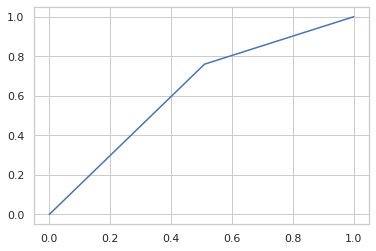

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.025507437977872
            Iterations: 12
            Function evaluations: 22
            Gradient evaluations: 12


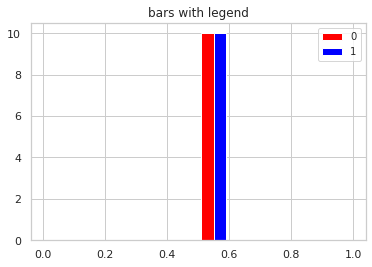

TEST_full_bayesian_0dot01_liver_with_seg_volumes: auc_score: 0.5


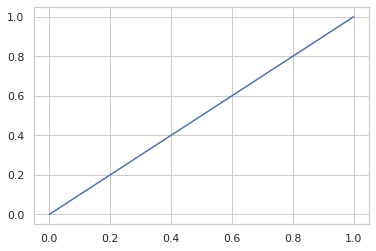

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.02550743797786
            Iterations: 12
            Function evaluations: 22
            Gradient evaluations: 12


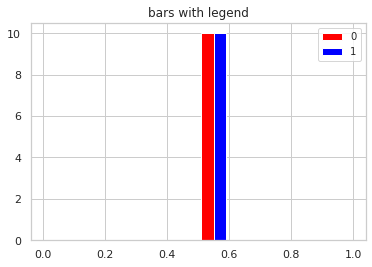

TEST_full_bayesian_0dot01_liver_with_seg_iou: auc_score: 0.5


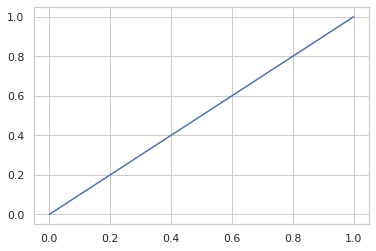

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.025508668706676
            Iterations: 16
            Function evaluations: 26
            Gradient evaluations: 16


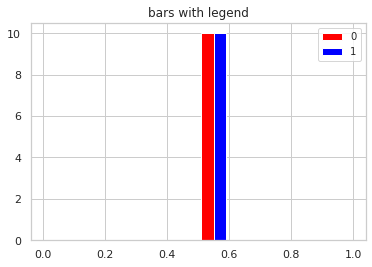

TEST_full_bayesian_0dot01_liver_with_seg_cvinv: auc_score: 0.5


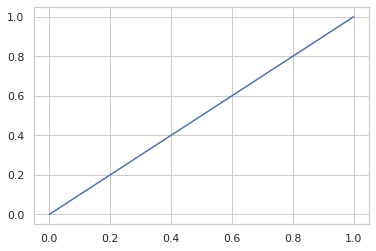

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.035274637100942
            Iterations: 12
            Function evaluations: 22
            Gradient evaluations: 12


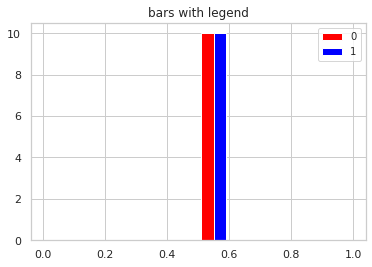

TEST_full_bayesian_0dot01_liver_with_seg_dot_iou: auc_score: 0.5


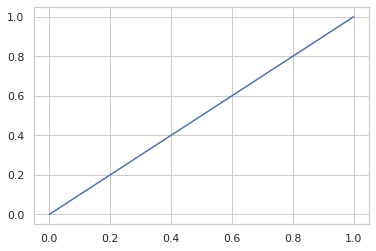

[[100   0]
 [ 50   0]]


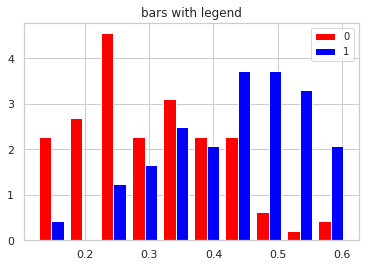

TEST_full_bayesian_0dot01_liver_with_seg_reg_iou: auc_score: 0.8158


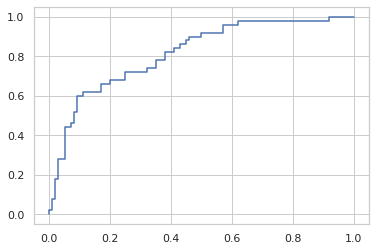

[[97  3]
 [36 14]]


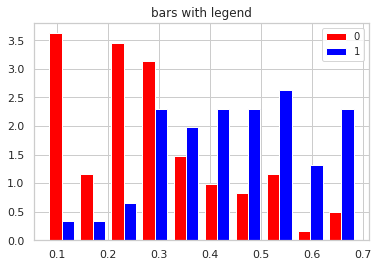

TEST_full_bayesian_0dot01_liver_with_seg_reg_cvinv: auc_score: 0.795


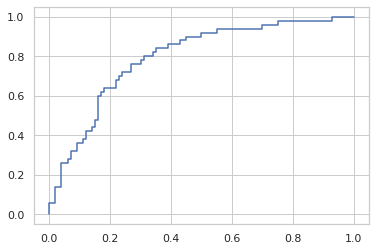

[[89 11]
 [31 19]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4708530529337158
            Iterations: 50
            Function evaluations: 56
            Gradient evaluations: 50


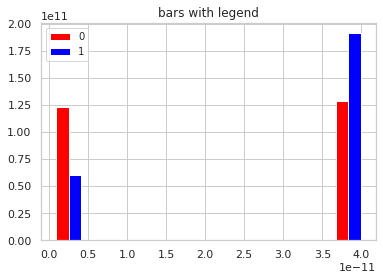

TEST_MC_dropout_quicknat_csv_features: auc_score: 0.625


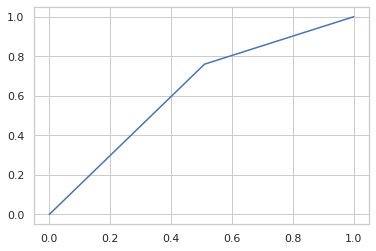

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.025224550898383
            Iterations: 13
            Function evaluations: 23
            Gradient evaluations: 13


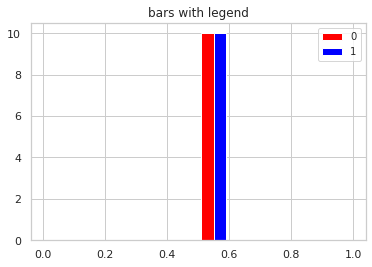

TEST_MC_dropout_quicknat_liver_with_seg_volumes: auc_score: 0.5


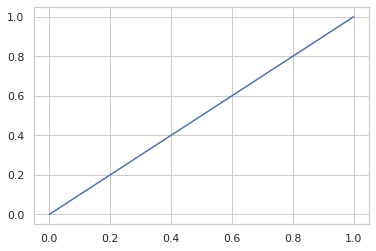

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.02522461460566
            Iterations: 14
            Function evaluations: 24
            Gradient evaluations: 14


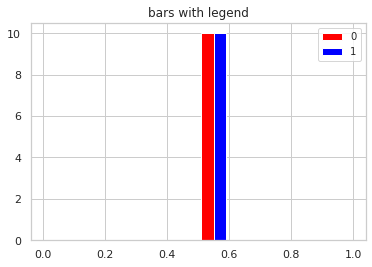

TEST_MC_dropout_quicknat_liver_with_seg_iou: auc_score: 0.5


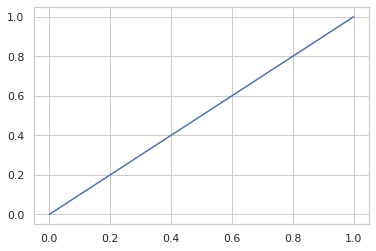

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.025224550059848
            Iterations: 18
            Function evaluations: 28
            Gradient evaluations: 18


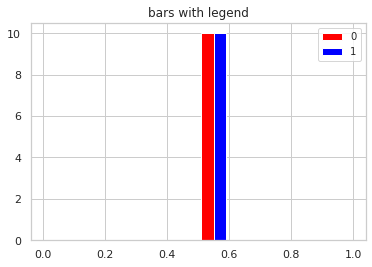

TEST_MC_dropout_quicknat_liver_with_seg_cvinv: auc_score: 0.5


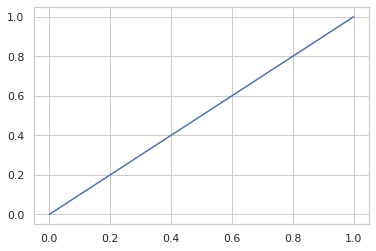

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.034832502332574
            Iterations: 14
            Function evaluations: 24
            Gradient evaluations: 14


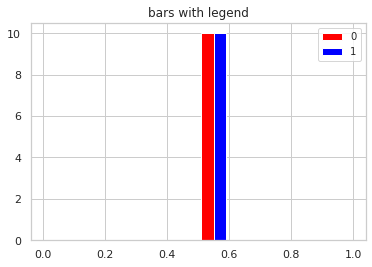

TEST_MC_dropout_quicknat_liver_with_seg_dot_iou: auc_score: 0.5


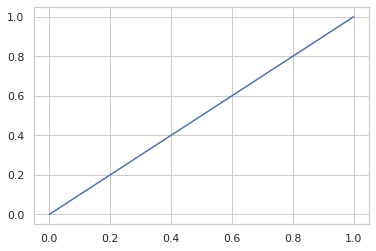

[[100   0]
 [ 50   0]]


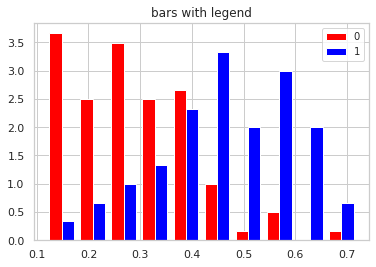

TEST_MC_dropout_quicknat_liver_with_seg_reg_iou: auc_score: 0.8436


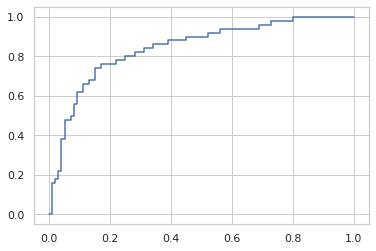

[[95  5]
 [29 21]]


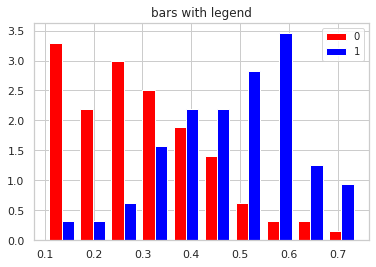

TEST_MC_dropout_quicknat_liver_with_seg_reg_cvinv: auc_score: 0.8414


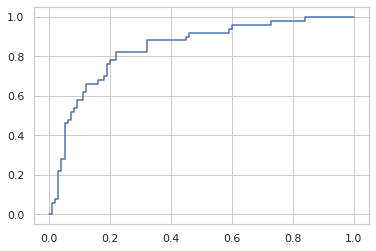

[[93  7]
 [25 25]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4708530529337158
            Iterations: 50
            Function evaluations: 56
            Gradient evaluations: 50


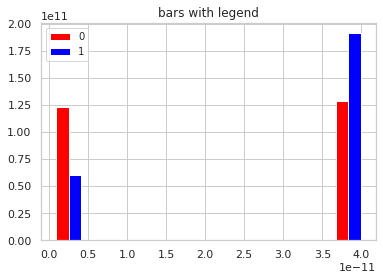

TEST_probabilistic_quicknat_csv_features: auc_score: 0.625


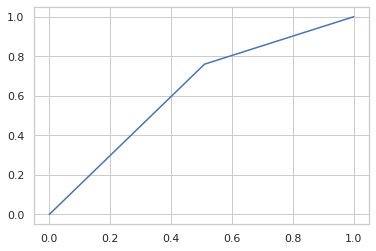

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.025296808029154
            Iterations: 13
            Function evaluations: 23
            Gradient evaluations: 13


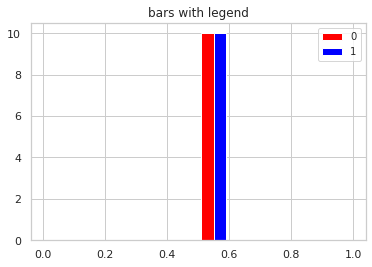

TEST_probabilistic_quicknat_liver_with_seg_volumes: auc_score: 0.5


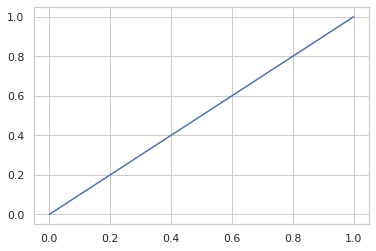

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.025296873035225
            Iterations: 13
            Function evaluations: 23
            Gradient evaluations: 13


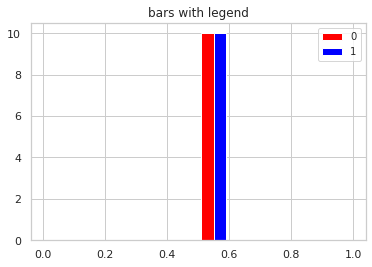

TEST_probabilistic_quicknat_liver_with_seg_iou: auc_score: 0.5


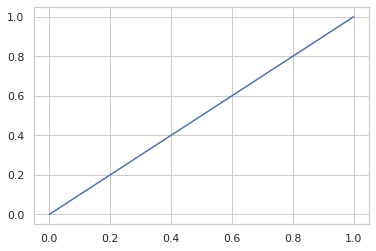

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.025296934778487
            Iterations: 19
            Function evaluations: 29
            Gradient evaluations: 19


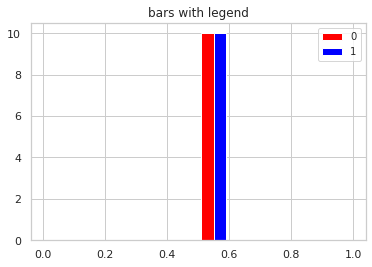

TEST_probabilistic_quicknat_liver_with_seg_cvinv: auc_score: 0.5


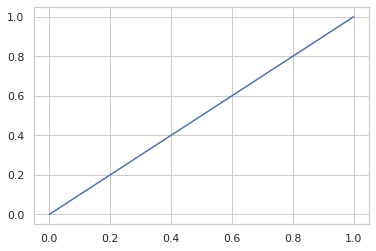

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.035992501164564
            Iterations: 13
            Function evaluations: 23
            Gradient evaluations: 13


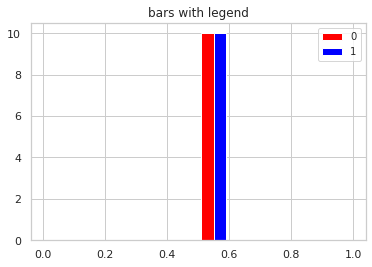

TEST_probabilistic_quicknat_liver_with_seg_dot_iou: auc_score: 0.5


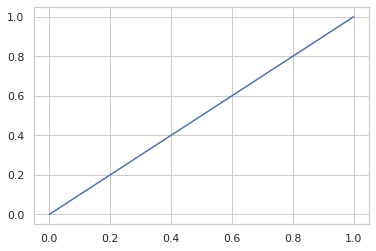

[[100   0]
 [ 50   0]]


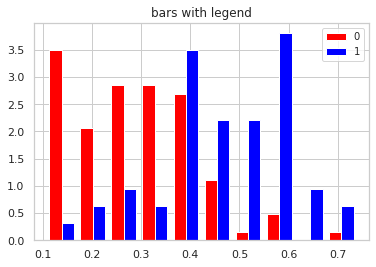

TEST_probabilistic_quicknat_liver_with_seg_reg_iou: auc_score: 0.8393999999999999


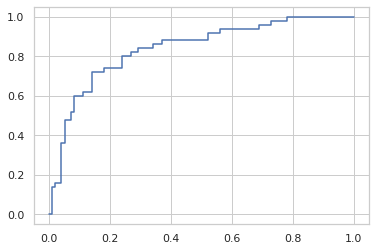

[[95  5]
 [27 23]]


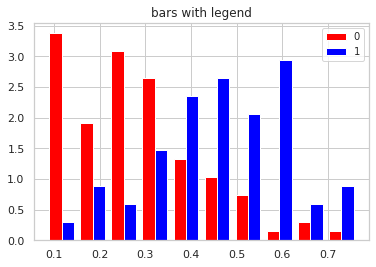

TEST_probabilistic_quicknat_liver_with_seg_reg_cvinv: auc_score: 0.8166


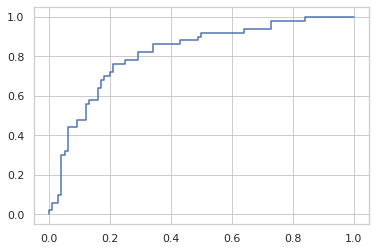

[[94  6]
 [28 22]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4708530529337158
            Iterations: 50
            Function evaluations: 56
            Gradient evaluations: 50


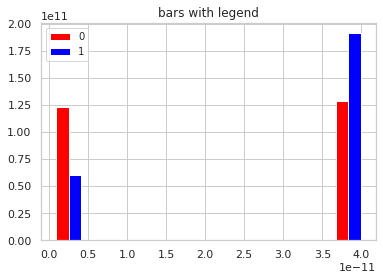

TEST_hierarchical_quicknat_csv_features: auc_score: 0.625


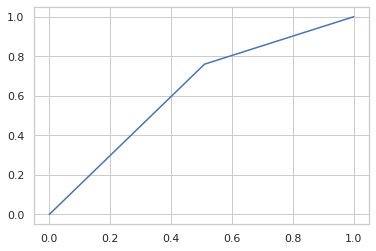

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.025255346487237
            Iterations: 13
            Function evaluations: 23
            Gradient evaluations: 13


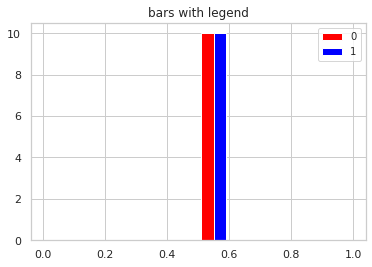

TEST_hierarchical_quicknat_liver_with_seg_volumes: auc_score: 0.5


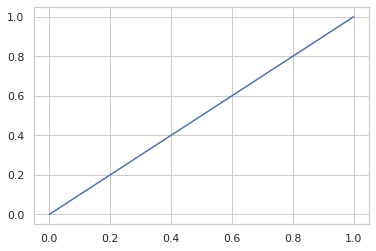

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.02525541074084
            Iterations: 13
            Function evaluations: 23
            Gradient evaluations: 13


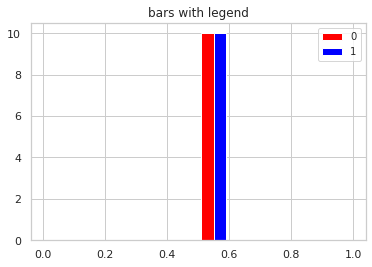

TEST_hierarchical_quicknat_liver_with_seg_iou: auc_score: 0.5


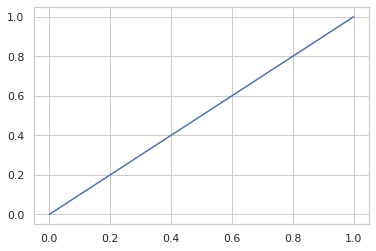

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.025255452931422
            Iterations: 19
            Function evaluations: 29
            Gradient evaluations: 19


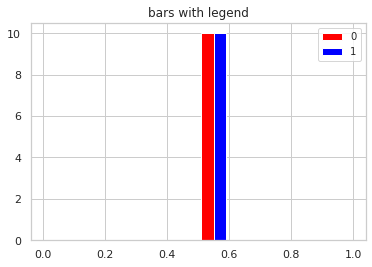

TEST_hierarchical_quicknat_liver_with_seg_cvinv: auc_score: 0.5


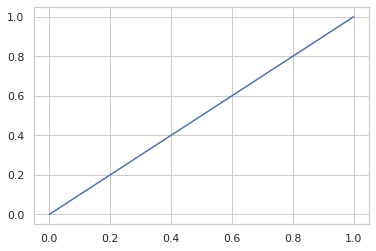

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.03587781632308
            Iterations: 13
            Function evaluations: 23
            Gradient evaluations: 13


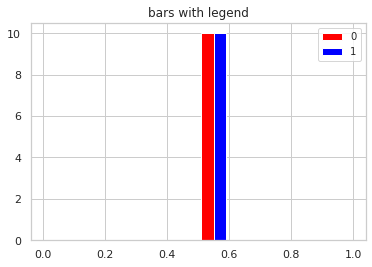

TEST_hierarchical_quicknat_liver_with_seg_dot_iou: auc_score: 0.5


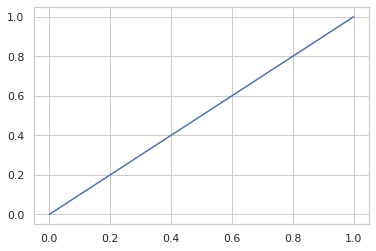

[[100   0]
 [ 50   0]]


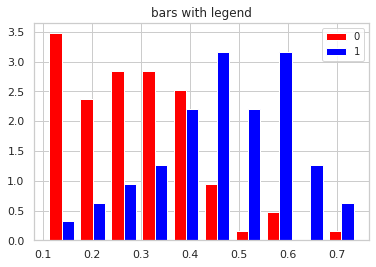

TEST_hierarchical_quicknat_liver_with_seg_reg_iou: auc_score: 0.8426000000000001


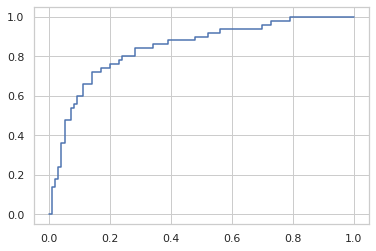

[[95  5]
 [27 23]]


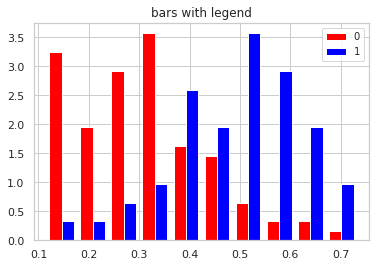

TEST_hierarchical_quicknat_liver_with_seg_reg_cvinv: auc_score: 0.8402000000000001


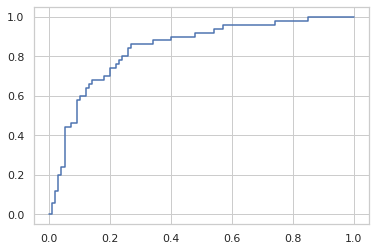

[[91  9]
 [23 27]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4708530529337157
            Iterations: 50
            Function evaluations: 56
            Gradient evaluations: 50


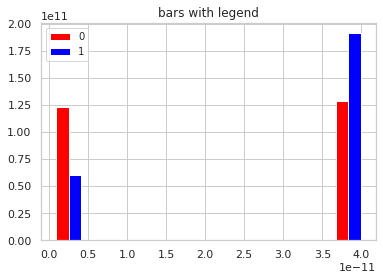

dataset_KORA_processed_csv_features: auc_score: 0.625


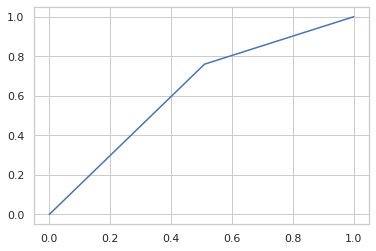

[[100   0]
 [ 50   0]]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12.025042014760105
            Iterations: 13
            Function evaluations: 23
            Gradient evaluations: 13


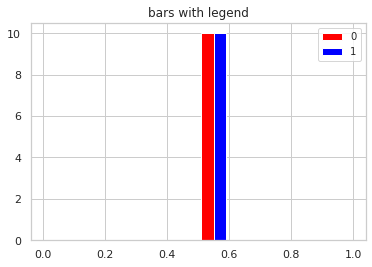

dataset_KORA_processed_liver_with_seg_volumes: auc_score: 0.5


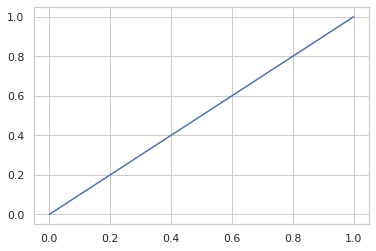

[[100   0]
 [ 50   0]]


,,,age,age_coeff,aic,auc,bic,bmi_numeric,bmi_numeric_coeff,const,const_coeff,cvinv,cvinv_coeff,f1,iou_dot_seg_liver,iou_dot_seg_liver_coeff,iou_liver,iou_liver_coeff,psuedo_r2,seg_liver,seg_liver_coeff,sex,sex_coeff
TEST_full_bayesian_0dot01_diabetes_status,diabetes_status,0,nan,0,2500.5,0.625,2506.52,nan,0,7.23157e-132,-7.11719,nan,nan,1,nan,nan,nan,nan,-12.0738,nan,nan,0.0645859,0.617704
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_volumes,diabetes_status_with_liver_seg_volumes,0,nan,0,207.944,0.5,207.944,nan,0,nan,0,nan,nan,1,nan,nan,nan,nan,-0.0889737,nan,0,nan,0
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_and_iou,diabetes_status_with_liver_seg_and_iou,0,nan,0,207.944,0.5,207.944,nan,0,nan,0,nan,nan,1,nan,nan,nan,0,-0.0889737,nan,0,nan,0
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_and_cvinv,diabetes_status_with_liver_seg_and_cvinv,0,nan,0,207.944,0.5,207.944,nan,0,nan,0,nan,0,1,nan,nan,nan,nan,-0.0889737,nan,0,nan,0
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_dot_iou,diabetes_status_with_liver_seg_dot_iou,0,nan,0,207.944,0.5,207.944,nan,0,nan,0,nan,nan,1,nan,0,nan,nan,-0.0889737,nan,0,nan,0
TEST_full_bayesian_0dot01_diabetes_status_with_liver_regularised_seg_volumes,diabetes_status_with_liver_regularised_seg_volumes,0,nan,nan,nan,0.8158,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan
TEST_full_bayesian_0dot01_diabetes_status_with_liver_regularised_seg_volumes_cvinv,diabetes_status_with_liver_regularised_seg_volumes_cvinv,0,nan,nan,nan,0.795,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan
TEST_MC_dropout_quicknat_diabetes_status,diabetes_status,0,nan,0,2500.5,0.625,2506.52,nan,0,7.23157e-132,-7.11719,nan,nan,1,nan,nan,nan,nan,-12.0738,nan,nan,0.0645859,0.617704
TEST_MC_dropout_quicknat_diabetes_status_with_liver_seg_volumes,diabetes_status_with_liver_seg_volumes,0,nan,0,207.944,0.5,207.944,nan,0,nan,0,nan,nan,1,nan,nan,nan,nan,-0.0889737,nan,0,nan,0
TEST_MC_dropout_quicknat_diabetes_status_with_liver_seg_and_iou,diabetes_status_with_liver_seg_and_iou,0,nan,0,207.944,0.5,207.944,nan,0,nan,0,nan,nan,1,nan,nan,nan,0,-0.0889737,nan,0,nan,0


In [11]:
feats = basic_feats
basic_feats = basic_feats
dicts = {}
anova_test_dicts = {}
global_kora_models = {}
# basic_feats = normalised_basic_feats
for model, df in dfs.items():
#     
#     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
#     df = df.fillna(0)

    dicts[model] = {}
    global_kora_models[model] = {}
    target_col = 'diabetes_status'
 
#   Equation 1 process
    p_values, statsmodel, y_yp = discrete_group_feature_stats(basic_feats, df, target_col, ['sex'], True)
#     print(y_yp)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_csv_features')
    dicts[model][target_col] = p_values
    dicts[model][target_col]['auc'] = auc_score
    dicts[model][target_col]['f1'] = f1_score
#     dicts, global_kora_models[model]['normal'] = aggregate_model_outputs(df, target_col, basic_feats, dicts, model, target_col)
    global_kora_models[model]['normal'] = statsmodel
#     for organ in ['spleen', 'liver']:
    organ = 'liver'
#     Equation 2 process
    feats = basic_feats + [ f'seg_{organ}']
    p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_volumes')
    dicts[model][target_col+f'_with_{organ}_seg_volumes'] = p_values
    dicts[model][target_col+f'_with_{organ}_seg_volumes']['auc'] = auc_score
    dicts[model][target_col+f'_with_{organ}_seg_volumes']['f1'] = f1_score
#     dicts, global_kora_models[model][f'{organ}_seg'] = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_with_{organ}_seg_volumes')
    global_kora_models[model][f'{organ}_seg'] = statsmodel
    
    if 'dataset' in model:
        continue

#     Equation 3 process
    feats = basic_feats + [ f'seg_{organ}', f'iou_{organ}']
    p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_iou')
    dicts[model][target_col+f'_with_{organ}_seg_and_iou'] = p_values
    dicts[model][target_col+f'_with_{organ}_seg_and_iou']['auc'] = auc_score
    dicts[model][target_col+f'_with_{organ}_seg_and_iou']['f1'] = f1_score
#     dicts, global_kora_models[model][f'{organ}_seg_iou'] = aggregate_model_outputs(df, target_col, feats, dicts, model,target_col+f'_with_{organ}_seg_and_iou')
    global_kora_models[model][f'{organ}_seg_iou'] = statsmodel
    
    #     Equation 3.2 process
    feats = basic_feats + [ f'seg_{organ}', f'cvinv']
    p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_cvinv')
    dicts[model][target_col+f'_with_{organ}_seg_and_cvinv'] = p_values
    dicts[model][target_col+f'_with_{organ}_seg_and_cvinv']['auc'] = auc_score
    dicts[model][target_col+f'_with_{organ}_seg_and_cvinv']['f1'] = f1_score
#     dicts, global_kora_models[model][f'{organ}_seg_iou'] = aggregate_model_outputs(df, target_col, feats, dicts, model,target_col+f'_with_{organ}_seg_and_iou')
    global_kora_models[model][f'{organ}_seg_cvinv'] = statsmodel
    
    
#     Equation 3.1 process
    feats = basic_feats + [f'seg_{organ}' , f'iou_dot_seg_{organ}']
    p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_dot_iou')
    dicts[model][target_col+f'_with_{organ}_seg_dot_iou'] = p_values
    dicts[model][target_col+f'_with_{organ}_seg_dot_iou']['auc'] = auc_score
    dicts[model][target_col+f'_with_{organ}_seg_dot_iou']['f1'] = f1_score
#     dicts, global_kora_models[model][f'{organ}_seg_dot_iou'] = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_with_{organ}_seg_dot_iou')
    global_kora_models[model][f'{organ}_seg_dot_iou'] = statsmodel


#     Equation 4 process
    feats = basic_feats + [ f'seg_{organ}']
    p_values, statsmodel, y_yp = discrete_weighted_group_feats(df, target_col, feats, f'iou_{organ}')
    auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_reg_iou')
    dicts[model][target_col+f'_with_{organ}_regularised_seg_volumes'] = p_values
    dicts[model][target_col+f'_with_{organ}_regularised_seg_volumes']['auc'] = auc_score
    dicts[model][target_col+f'_with_{organ}_regularised_seg_volumes']['f1'] = f1_score
#     dicts, global_kora_models[model][f'{organ}_seg_reg_iou'] = aggregate_model_outputs(df, target_col, feats,  dicts, model, target_col+f'_with_{organ}_regularised_seg_volumes',None,  f'iou_mean')
    global_kora_models[model][f'{organ}_seg_reg_iou'] =  statsmodel
    
    #     Equation 4.1 process
    feats = basic_feats + [ f'seg_{organ}']
    p_values, statsmodel, y_yp = discrete_weighted_group_feats(df, target_col, feats, f'cvinv')
    auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_reg_cvinv')
    dicts[model][target_col+f'_with_{organ}_regularised_seg_volumes_cvinv'] = p_values
    dicts[model][target_col+f'_with_{organ}_regularised_seg_volumes_cvinv']['auc'] = auc_score
    dicts[model][target_col+f'_with_{organ}_regularised_seg_volumes_cvinv']['f1'] = f1_score
#     dicts, global_kora_models[model][f'{organ}_seg_reg_iou'] = aggregate_model_outputs(df, target_col, feats,  dicts, model, target_col+f'_with_{organ}_regularised_seg_volumes',None,  f'iou_mean')
    global_kora_models[model][f'{organ}_seg_reg_cvinv'] =  statsmodel

    
p_value_df_ka = df_from_nested_dicts(dicts).T
p_value_df_styler_ka = highlight_significance(p_value_df_ka, 0.05)
p_value_df_styler_ka

In [12]:
p_value_df_ka[['auc' ]]

,,,auc
TEST_full_bayesian_0dot01_diabetes_status,diabetes_status,0,0.6250
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_volumes,diabetes_status_with_liver_seg_volumes,0,0.5000
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_and_iou,diabetes_status_with_liver_seg_and_iou,0,0.5000
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_and_cvinv,diabetes_status_with_liver_seg_and_cvinv,0,0.5000
TEST_full_bayesian_0dot01_diabetes_status_with_liver_seg_dot_iou,diabetes_status_with_liver_seg_dot_iou,0,0.5000
TEST_full_bayesian_0dot01_diabetes_status_with_liver_regularised_seg_volumes,diabetes_status_with_liver_regularised_seg_volumes,0,0.8158
TEST_full_bayesian_0dot01_diabetes_status_with_liver_regularised_seg_volumes_cvinv,diabetes_status_with_liver_regularised_seg_volumes_cvinv,0,0.7950
TEST_MC_dropout_quicknat_diabetes_status,diabetes_status,0,0.6250
TEST_MC_dropout_quicknat_diabetes_status_with_liver_seg_volumes,diabetes_status_with_liver_seg_volumes,0,0.5000
TEST_MC_dropout_quicknat_diabetes_status_with_liver_seg_and_iou,diabetes_status_with_liver_seg_and_iou,0,0.5000


TEST_full_bayesian_0dot01


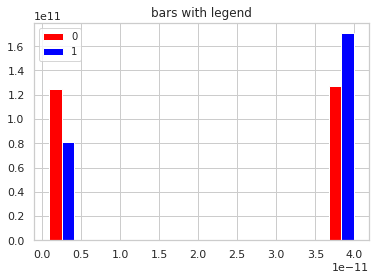

ensemble: auc_score: 0.5867604617604618


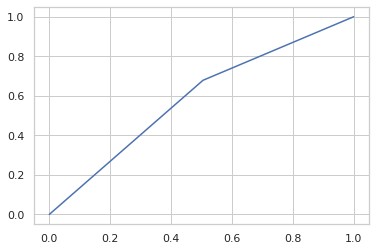

[[99  0]
 [56  0]]


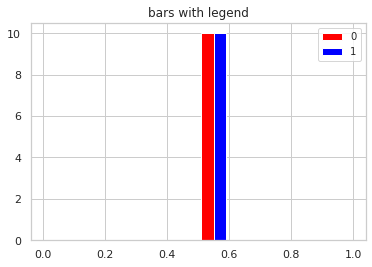

ensemble: auc_score: 0.5


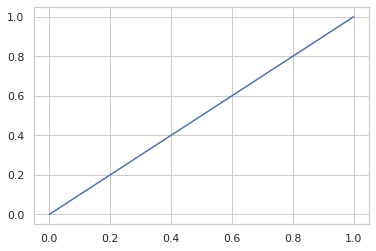

[[99  0]
 [56  0]]


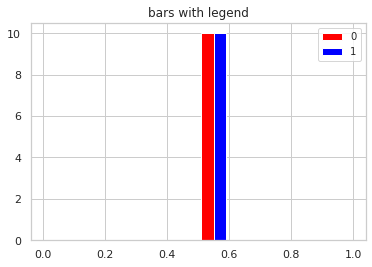

ensemble: auc_score: 0.5


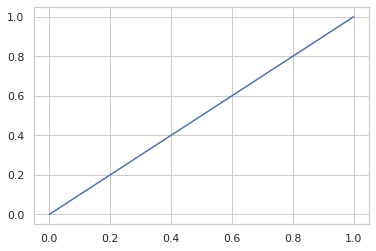

[[99  0]
 [56  0]]


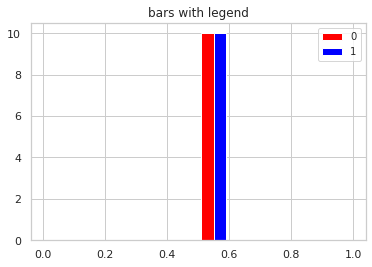

ensemble: auc_score: 0.5


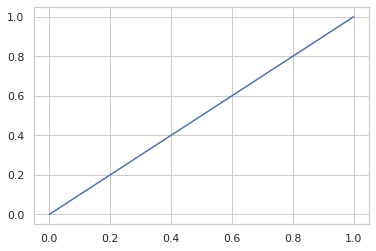

[[99  0]
 [56  0]]


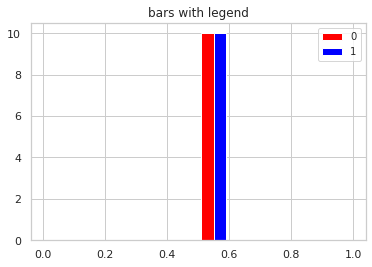

ensemble: auc_score: 0.5


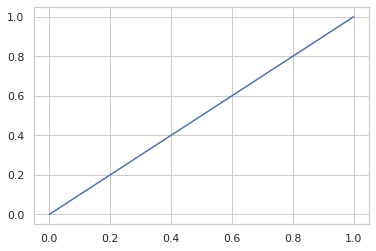

[[99  0]
 [56  0]]


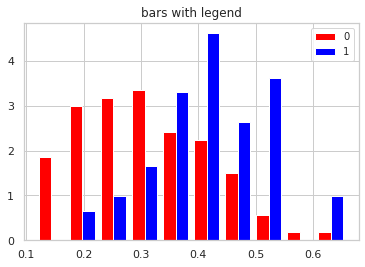

ensemble: auc_score: 0.7757936507936508


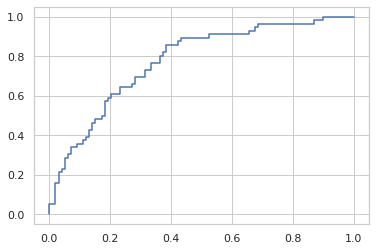

[[94  5]
 [43 13]]


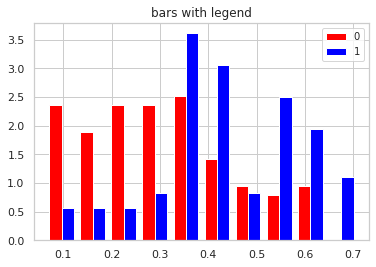

ensemble: auc_score: 0.7545093795093796


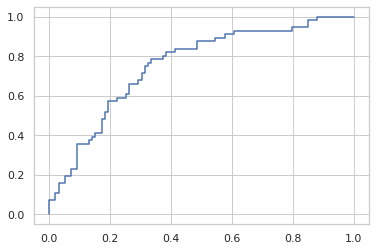

[[88 11]
 [36 20]]
TEST_hierarchical_quicknat


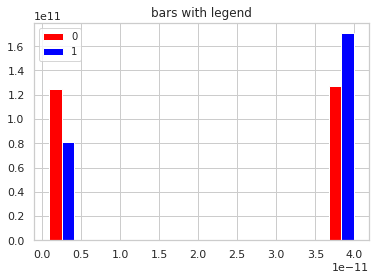

ensemble: auc_score: 0.5867604617604618


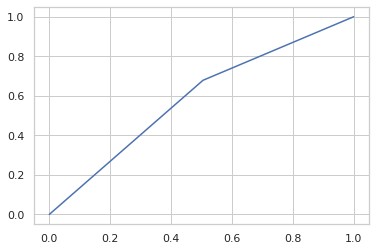

[[99  0]
 [56  0]]


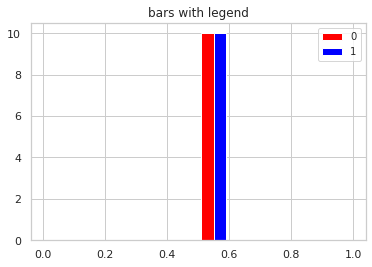

ensemble: auc_score: 0.5


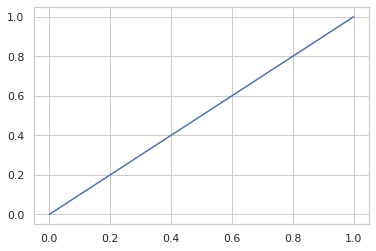

[[99  0]
 [56  0]]


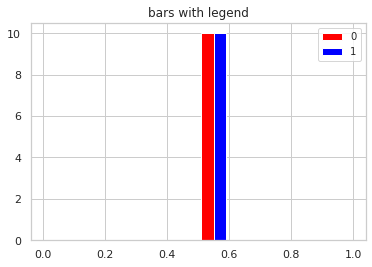

ensemble: auc_score: 0.5


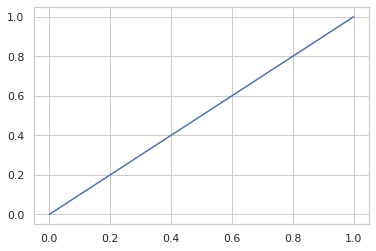

[[99  0]
 [56  0]]


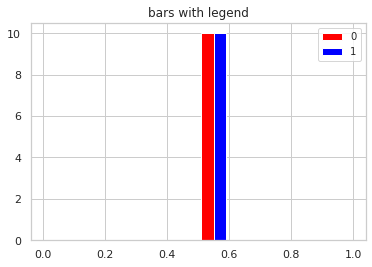

ensemble: auc_score: 0.5


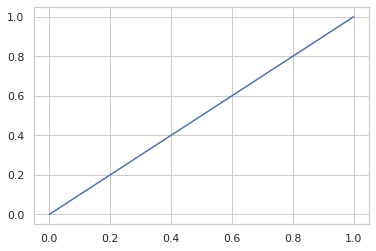

[[99  0]
 [56  0]]


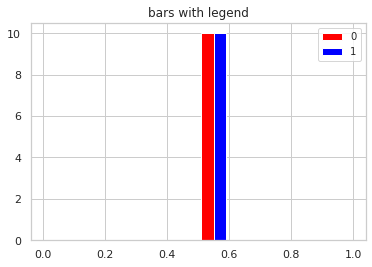

ensemble: auc_score: 0.5


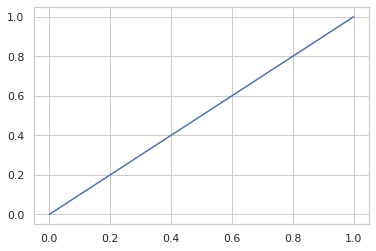

[[99  0]
 [56  0]]


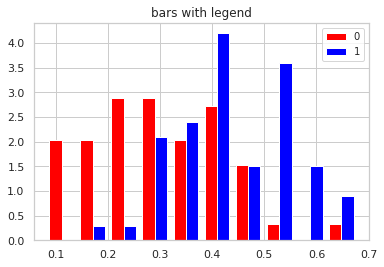

ensemble: auc_score: 0.791125541125541


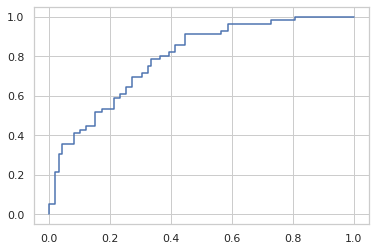

[[95  4]
 [36 20]]


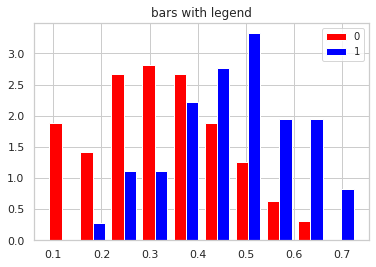

ensemble: auc_score: 0.7918470418470418


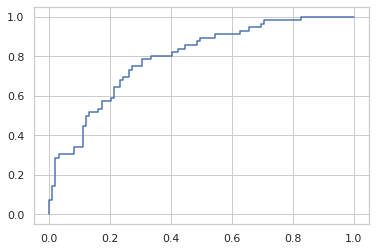

[[88 11]
 [34 22]]
TEST_MC_dropout_quicknat


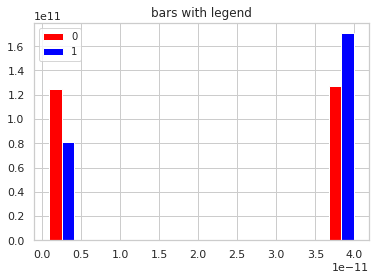

ensemble: auc_score: 0.5867604617604618


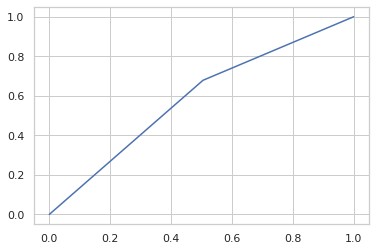

[[99  0]
 [56  0]]


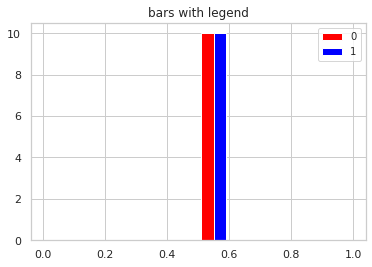

ensemble: auc_score: 0.5


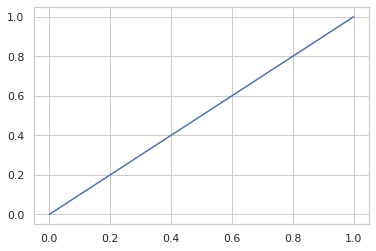

[[99  0]
 [56  0]]


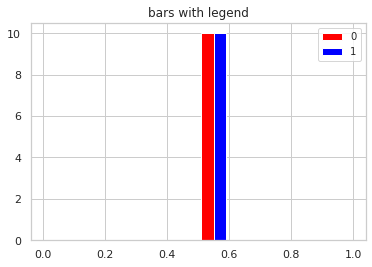

ensemble: auc_score: 0.5


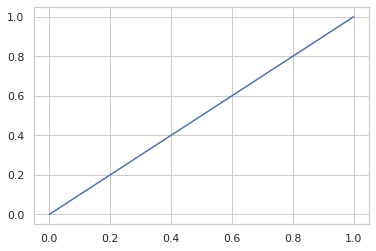

[[99  0]
 [56  0]]


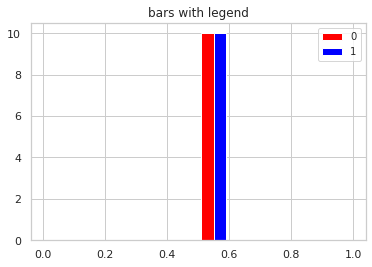

ensemble: auc_score: 0.5


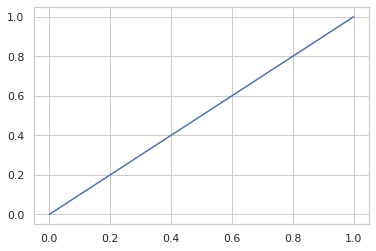

[[99  0]
 [56  0]]


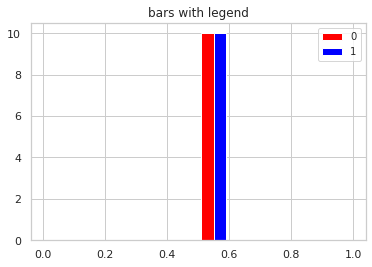

ensemble: auc_score: 0.5


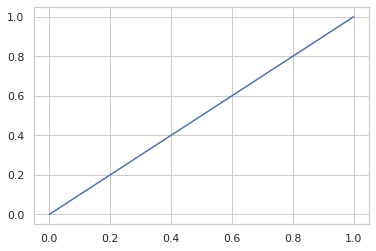

[[99  0]
 [56  0]]


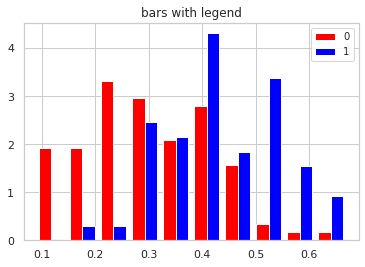

ensemble: auc_score: 0.7938311688311689


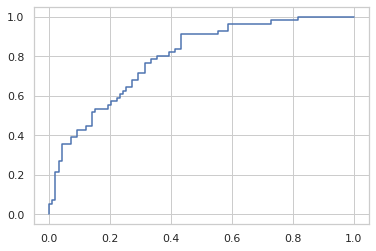

[[95  4]
 [37 19]]


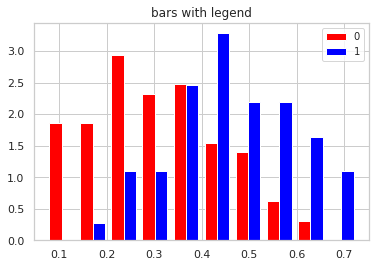

ensemble: auc_score: 0.7923881673881673


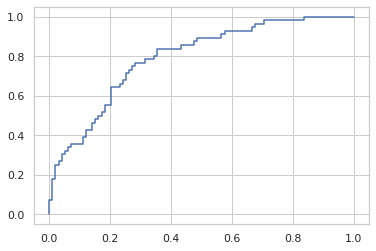

[[88 11]
 [35 21]]
TEST_probabilistic_quicknat


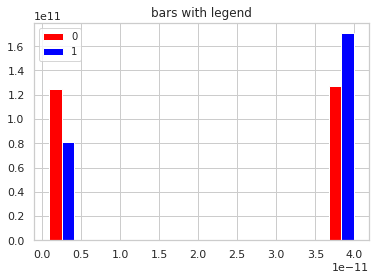

ensemble: auc_score: 0.5867604617604618


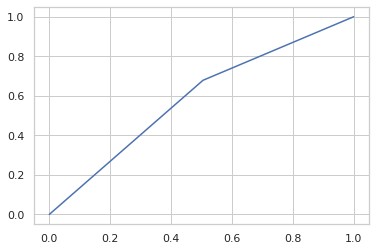

[[99  0]
 [56  0]]


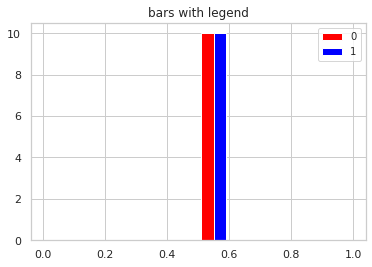

ensemble: auc_score: 0.5


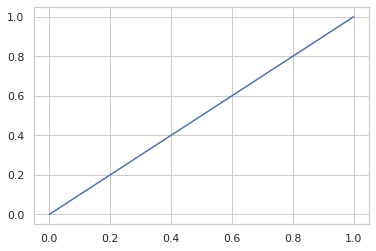

[[99  0]
 [56  0]]


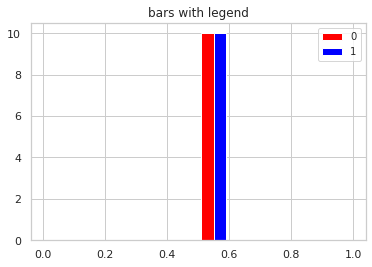

ensemble: auc_score: 0.5


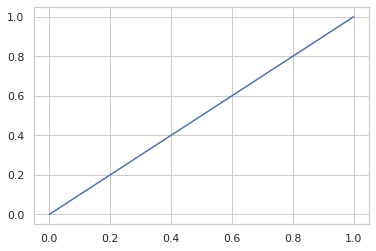

[[99  0]
 [56  0]]


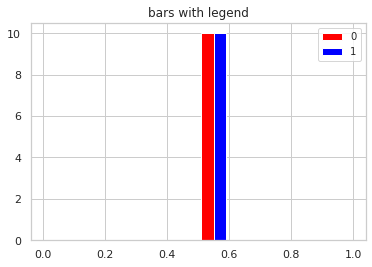

ensemble: auc_score: 0.5


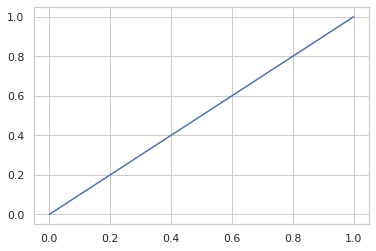

[[99  0]
 [56  0]]


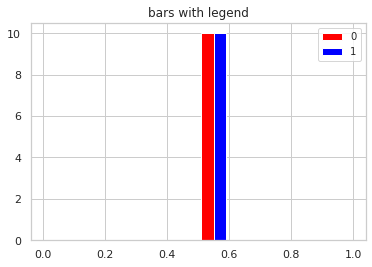

ensemble: auc_score: 0.5


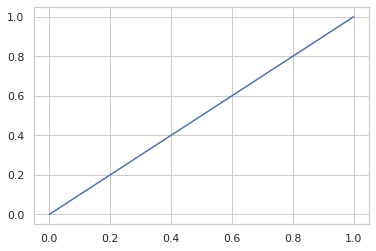

[[99  0]
 [56  0]]


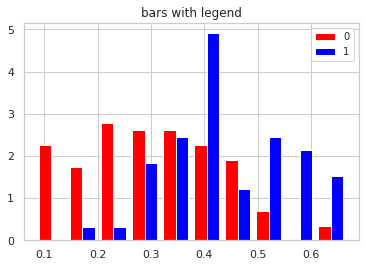

ensemble: auc_score: 0.7851731601731602


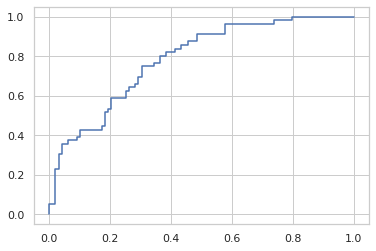

[[94  5]
 [36 20]]


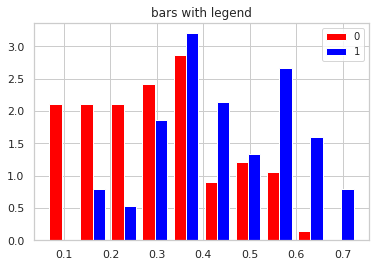

ensemble: auc_score: 0.7622655122655123


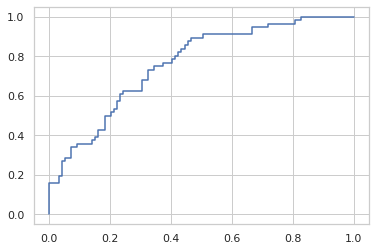

[[88 11]
 [36 20]]
dataset_KORA_processed


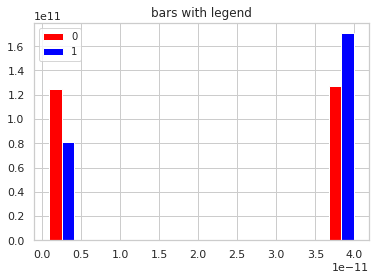

ensemble: auc_score: 0.5867604617604618


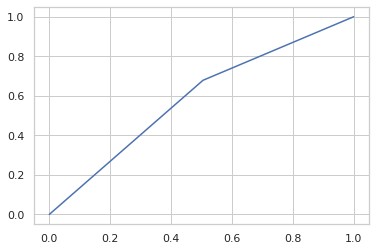

[[99  0]
 [56  0]]


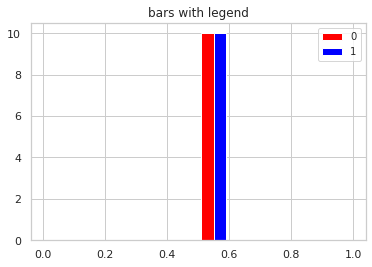

ensemble: auc_score: 0.5


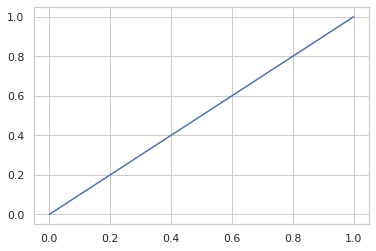

[[99  0]
 [56  0]]


,,,v_scoring,v_scoring_with_weight,v_auc
TRAIN_full_bayesian_0dot01_diabetes_status,diabetes_status,0,1,1,0.58676
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_volumes,diabetes_status_liver_with_seg_volumes,0,1,1,0.5
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_and_iou,diabetes_status_liver_with_seg_and_iou,0,1,1,0.5
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_and_cvinv,diabetes_status_liver_with_seg_and_cvinv,0,1,1,0.5
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_dot_iou,diabetes_status_liver_with_seg_dot_iou,0,1,1,0.5
TRAIN_full_bayesian_0dot01_diabetes_status_liver_seg_reg_iou,diabetes_status_liver_seg_reg_iou,0,1,1,0.775794
TRAIN_full_bayesian_0dot01_diabetes_status_liver_seg_reg_cvinv,diabetes_status_liver_seg_reg_cvinv,0,1,1,0.754509
TRAIN_hierarchical_quicknat_diabetes_status,diabetes_status,0,1,1,0.58676
TRAIN_hierarchical_quicknat_diabetes_status_liver_with_seg_volumes,diabetes_status_liver_with_seg_volumes,0,1,1,0.5
TRAIN_hierarchical_quicknat_diabetes_status_liver_with_seg_and_iou,diabetes_status_liver_with_seg_and_iou,0,1,1,0.5


In [13]:
feats = basic_feats
dicts = {}
anova_test_dicts = {}
# basic_feats = normalised_basic_feats
for model, df in dfs_train.items():
#     
#     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
#     df = df.fillna(0)
#     print(model)
#     if 'UKB' not in model:
# #         print('dataset cannot be processed!')
#         continue

    
#     print(df.columns)
#     break
    dicts[model] = {}
    k_mod = 'TEST' + model[5:]
    if 'dataset' in model:
        k_mod = model
        
    print(k_mod)
#     continue
    target_col = 'diabetes_status'
#     try:
#     Equation 1 process
#     p_values, statsmodel, y_yp = discrete_group_feature_stats(basic_feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_csv_feats')
    dicts[model][target_col] = {} #p_values
#         dicts[model][target_col]['auc'] = auc_score
#         dicts[model][target_col]['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, basic_feats, dicts, model, target_col, global_kora_models[k_mod]['normal'])

#     Equation 2 process
#     for organ in ['spleen', 'liver']:
    organ = 'liver'
    feats = basic_feats + [ f'seg_{organ}']
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_seg')
    dicts[model][target_col+f'_{organ}_with_seg_volumes'] = {} #p_values
#         dicts[model][target_col+f'_{organ}_with_seg_volumes']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_with_seg_volumes']['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_with_seg_volumes', global_kora_models[k_mod][f'{organ}_seg'])

    if 'dataset' in model:
        continue
        
#     Equation 3 process
    feats = basic_feats + [ f'seg_{organ}', f'iou_{organ}']
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_seg_iou')
    dicts[model][target_col+f'_{organ}_with_seg_and_iou'] = {} #p_values
#         dicts[model][target_col+f'_{organ}_with_seg_and_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_with_seg_and_iou']['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_with_seg_and_iou', global_kora_models[k_mod][f'{organ}_seg_iou'])

    #     Equation 3.2 process
    feats = basic_feats + [ f'seg_{organ}', f'cvinv']
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_seg_iou')
    dicts[model][target_col+f'_{organ}_with_seg_and_cvinv'] = {} #p_values
#         dicts[model][target_col+f'_{organ}_with_seg_and_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_with_seg_and_iou']['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_with_seg_and_cvinv', global_kora_models[k_mod][f'{organ}_seg_cvinv'])

    
    feats = basic_feats + [ f'seg_{organ}',   f'iou_dot_seg_{organ}']
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_seg_dot_iou')
    dicts[model][target_col+f'_{organ}_with_seg_dot_iou'] = {} #p_values
#         dicts[model][target_col+f'_{organ}_with_seg_dot_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_with_seg_dot_iou']['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_with_seg_dot_iou', global_kora_models[k_mod][f'{organ}_seg_dot_iou'])


    #     Equation 4.0 process
    feats = basic_feats + [ f'seg_{organ}']
#         p_values, statsmodel, y_yp = discrete_weighted_group_feats(df, target_col, feats, f'iou_mean')
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_csv_feats')
    dicts[model][target_col+f'_{organ}_seg_reg_iou'] = {} #p_values
#         dicts[model][target_col+f'_{organ}_seg_reg_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_seg_reg_iou']['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_seg_reg_iou', global_kora_models[k_mod][f'{organ}_seg_reg_iou'], 'iou_liver')

     #     Equation 4.0 process
    feats = basic_feats + [ f'seg_{organ}']
#         p_values, statsmodel, y_yp = discrete_weighted_group_feats(df, target_col, feats, f'iou_mean')
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_csv_feats')
    dicts[model][target_col+f'_{organ}_seg_reg_cvinv'] = {} #p_values
#         dicts[model][target_col+f'_{organ}_seg_reg_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_seg_reg_iou']['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_seg_reg_cvinv', global_kora_models[k_mod][f'{organ}_seg_reg_cvinv'], 'cvinv')
    
    # #     Equation 4.1 process
#     feats = basic_feats + [ 'seg_spleen_normalised']
#     p_values, statsmodel = discrete_weighted_group_feats(df, target_col, feats, 'iou_spleen')
#     dicts[model][target_col+'_reg_iou_spleen'] = p_values

    #     #     Equation 4.2 process
    #     feats = basic_feats + [ 'seg_liver_normalised']
    #     p_values, statsmodel = discrete_weighted_group_feats(df, target_col, feats, 'iou_liver')
    #     dicts[model][target_col+'_reg_iou_liver'] = p_values
#     except Exception as e:
#         print('ERRROR::', e)
#         continue

p_value_df_a = df_from_nested_dicts(dicts).T
p_value_df_styler_a = highlight_significance(p_value_df_a, 0.05)
p_value_df_styler_a

In [14]:
p_value_df_a[['v_auc' ]]

,,,v_auc
TRAIN_full_bayesian_0dot01_diabetes_status,diabetes_status,0,0.586760
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_volumes,diabetes_status_liver_with_seg_volumes,0,0.500000
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_and_iou,diabetes_status_liver_with_seg_and_iou,0,0.500000
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_and_cvinv,diabetes_status_liver_with_seg_and_cvinv,0,0.500000
TRAIN_full_bayesian_0dot01_diabetes_status_liver_with_seg_dot_iou,diabetes_status_liver_with_seg_dot_iou,0,0.500000
TRAIN_full_bayesian_0dot01_diabetes_status_liver_seg_reg_iou,diabetes_status_liver_seg_reg_iou,0,0.775794
TRAIN_full_bayesian_0dot01_diabetes_status_liver_seg_reg_cvinv,diabetes_status_liver_seg_reg_cvinv,0,0.754509
TRAIN_hierarchical_quicknat_diabetes_status,diabetes_status,0,0.586760
TRAIN_hierarchical_quicknat_diabetes_status_liver_with_seg_volumes,diabetes_status_liver_with_seg_volumes,0,0.500000
TRAIN_hierarchical_quicknat_diabetes_status_liver_with_seg_and_iou,diabetes_status_liver_with_seg_and_iou,0,0.500000


UKB_full_bayesian_0dot01
TEST_full_bayesian_0dot01


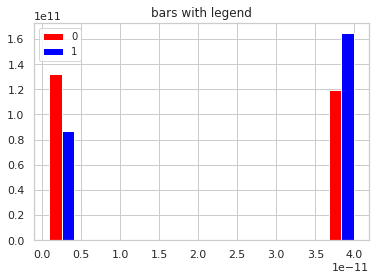

ensemble: auc_score: 0.5896039694394755


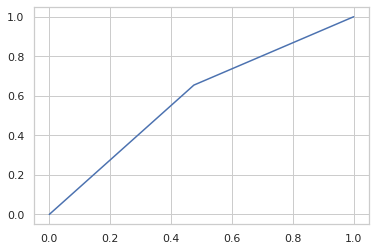

[[13273     0]
 [  697     0]]


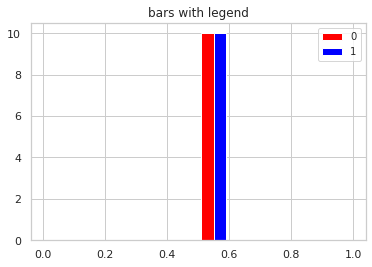

ensemble: auc_score: 0.5


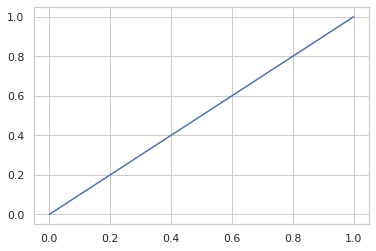

[[13273     0]
 [  697     0]]


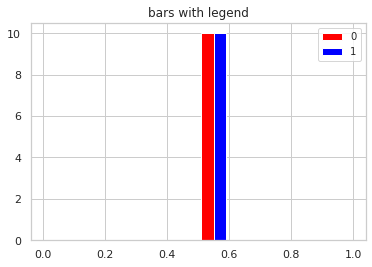

ensemble: auc_score: 0.5


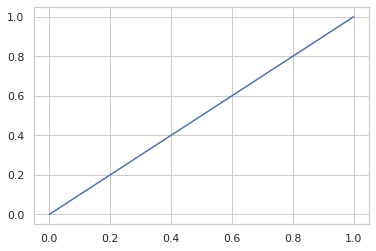

[[13273     0]
 [  697     0]]


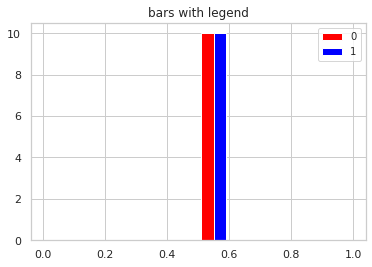

ensemble: auc_score: 0.5


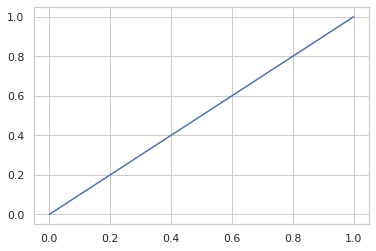

[[13273     0]
 [  697     0]]


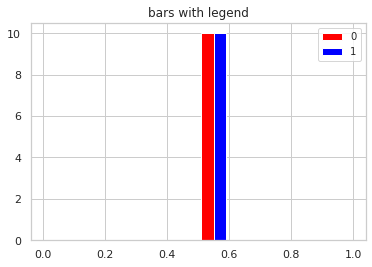

ensemble: auc_score: 0.5


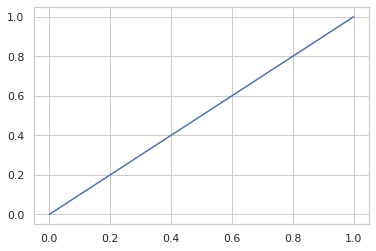

[[13273     0]
 [  697     0]]


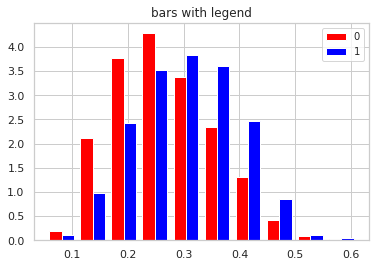

ensemble: auc_score: 0.6234558219559


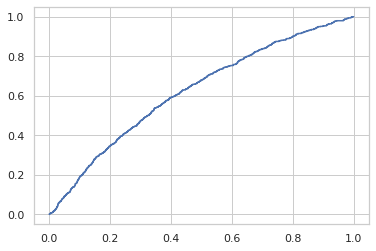

[[13190    83]
 [  691     6]]


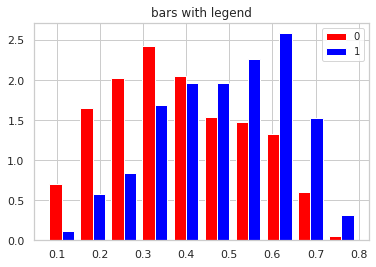

ensemble: auc_score: 0.6810861112098963


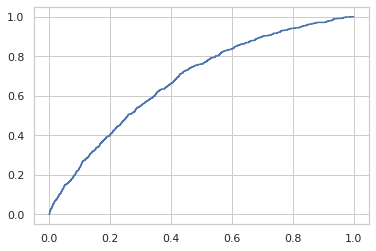

[[9802 3471]
 [ 344  353]]
UKB_MC_dropout_quicknat
TEST_MC_dropout_quicknat


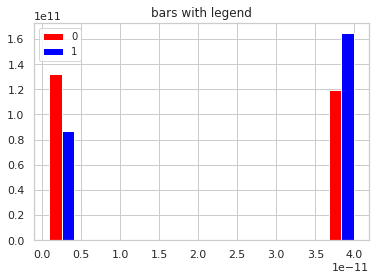

ensemble: auc_score: 0.5896039694394755


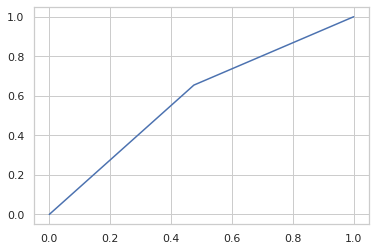

[[13273     0]
 [  697     0]]


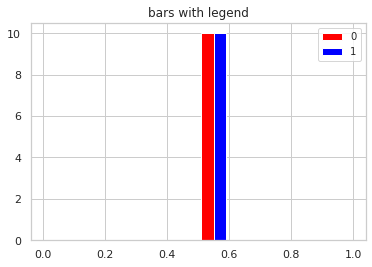

ensemble: auc_score: 0.5


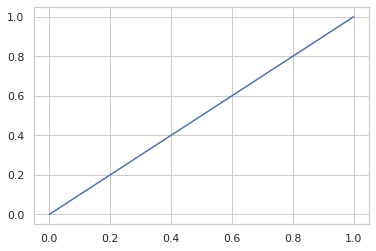

[[13273     0]
 [  697     0]]


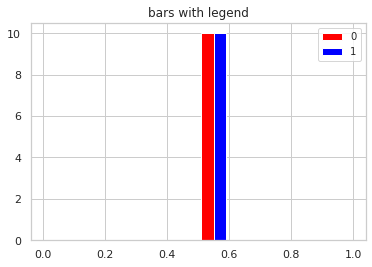

ensemble: auc_score: 0.5


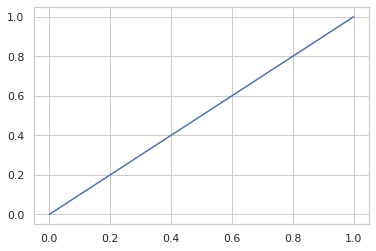

[[13273     0]
 [  697     0]]


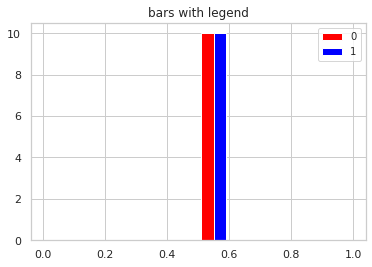

ensemble: auc_score: 0.5


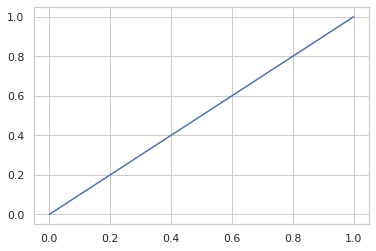

[[13273     0]
 [  697     0]]


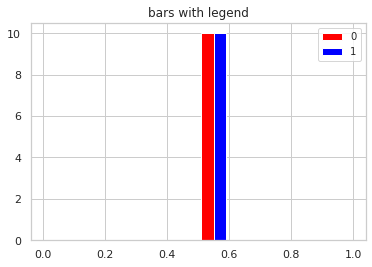

ensemble: auc_score: 0.5


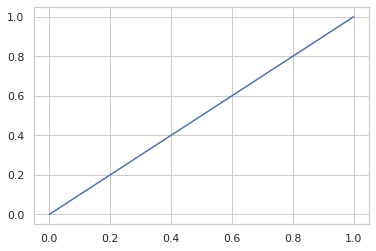

[[13273     0]
 [  697     0]]


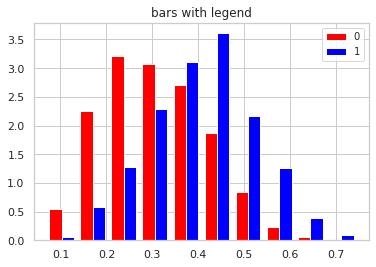

ensemble: auc_score: 0.7281028432711103


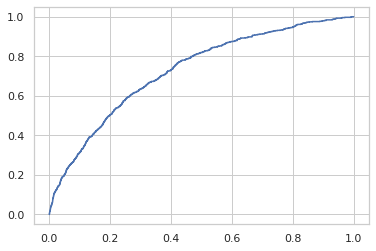

[[12657   616]
 [  563   134]]


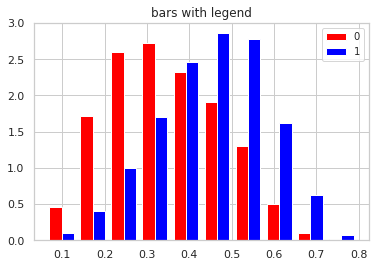

ensemble: auc_score: 0.716432783740976


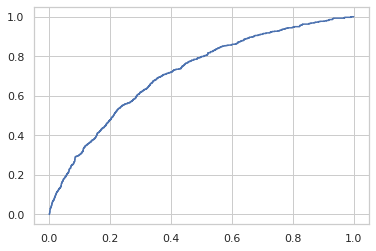

[[11363  1910]
 [  434   263]]
UKB_probabilistic_quicknat
TEST_probabilistic_quicknat


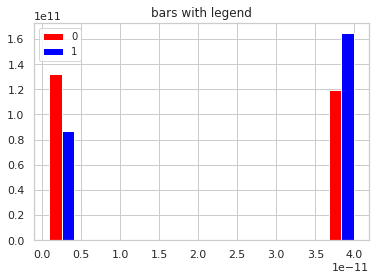

ensemble: auc_score: 0.5896039694394755


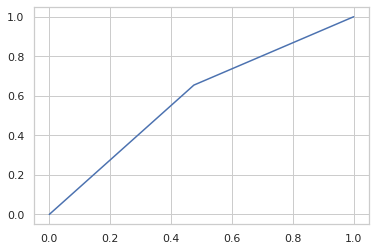

[[13273     0]
 [  697     0]]


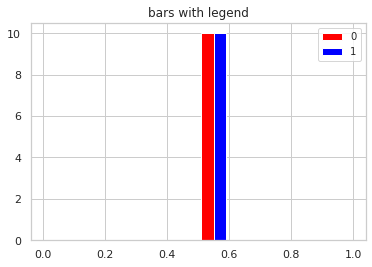

ensemble: auc_score: 0.5


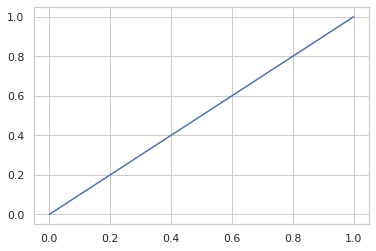

[[13273     0]
 [  697     0]]


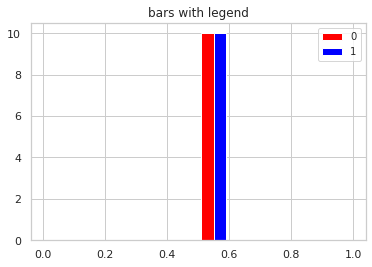

ensemble: auc_score: 0.5


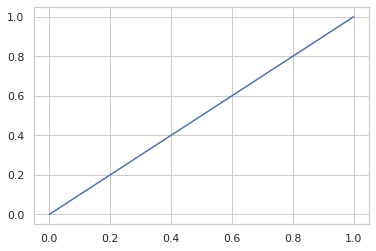

[[13273     0]
 [  697     0]]


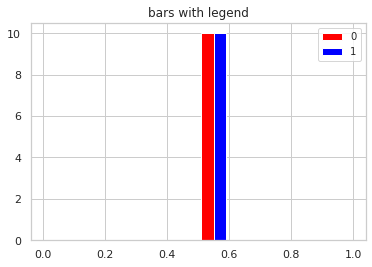

ensemble: auc_score: 0.5


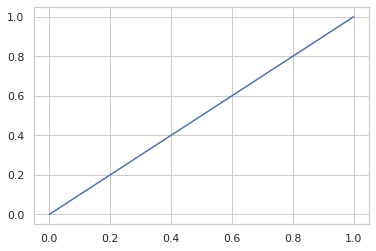

[[13273     0]
 [  697     0]]


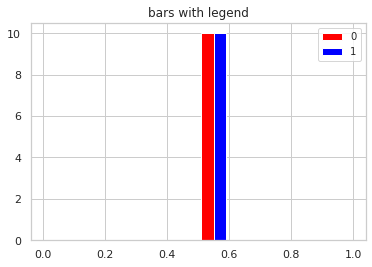

ensemble: auc_score: 0.5


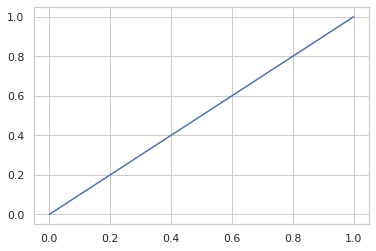

[[13273     0]
 [  697     0]]


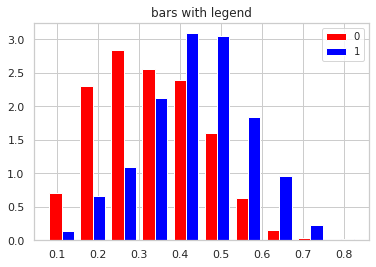

ensemble: auc_score: 0.7258503984475231


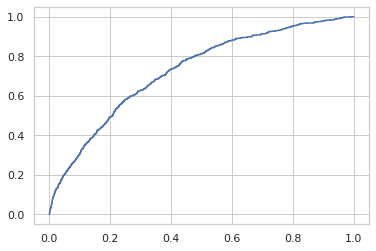

[[11938  1335]
 [  483   214]]


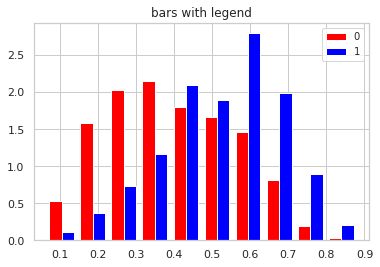

ensemble: auc_score: 0.7138455744669305


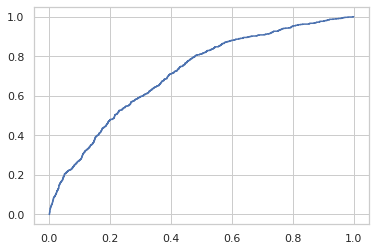

[[9398 3875]
 [ 286  411]]
UKB_hierarchical_quicknat
TEST_hierarchical_quicknat


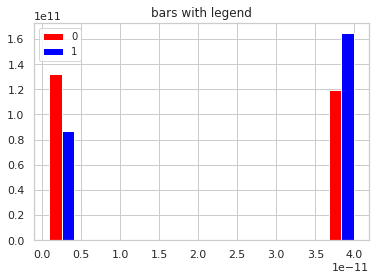

ensemble: auc_score: 0.5896039694394755


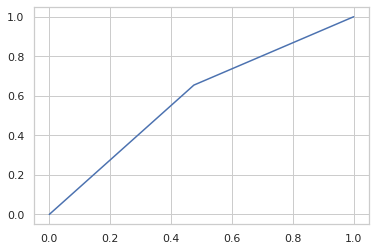

[[13273     0]
 [  697     0]]


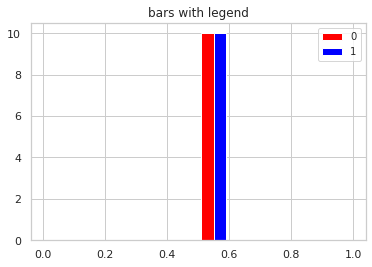

ensemble: auc_score: 0.5


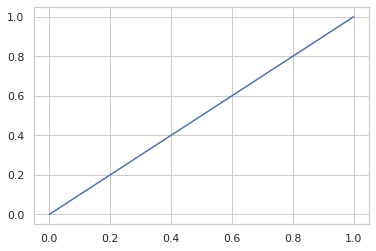

[[13273     0]
 [  697     0]]


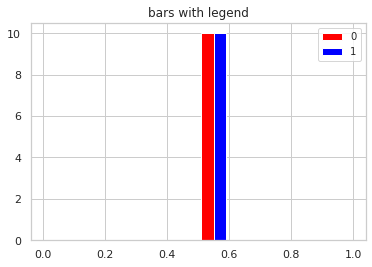

ensemble: auc_score: 0.5


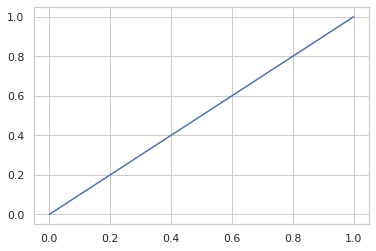

[[13273     0]
 [  697     0]]


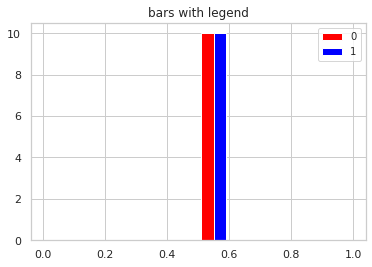

ensemble: auc_score: 0.5


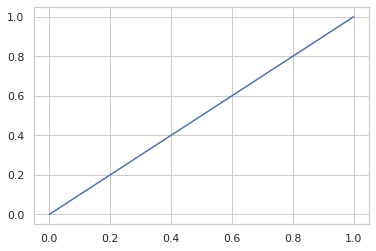

[[13273     0]
 [  697     0]]


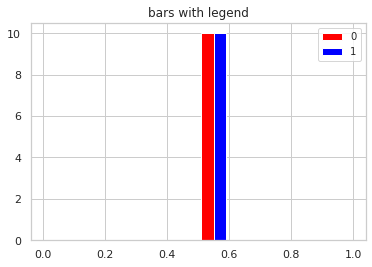

ensemble: auc_score: 0.5


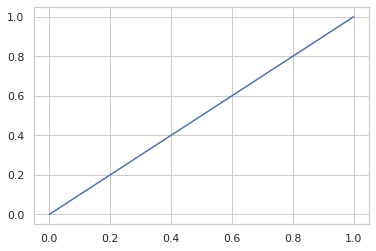

[[13273     0]
 [  697     0]]


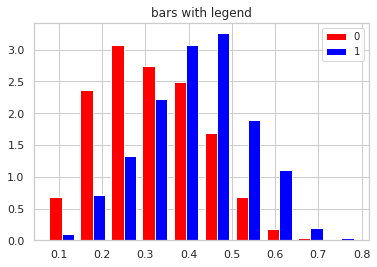

ensemble: auc_score: 0.7248005978847687


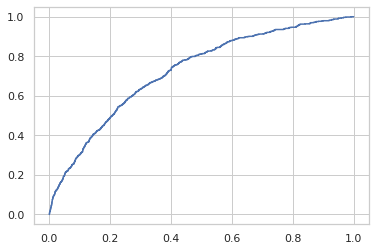

[[12383   890]
 [  534   163]]


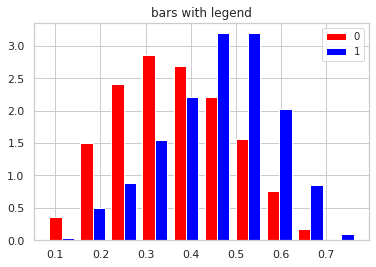

ensemble: auc_score: 0.7070408952014321


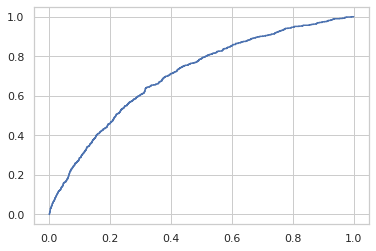

[[11184  2089]
 [  415   282]]
dataset_UKB_processed
dataset_KORA_processed


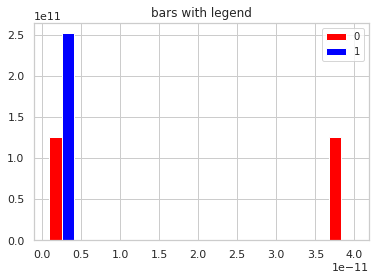

ensemble: auc_score: 0.25


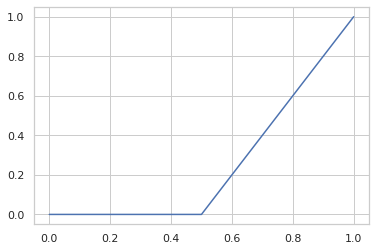

[[6 0]
 [1 0]]


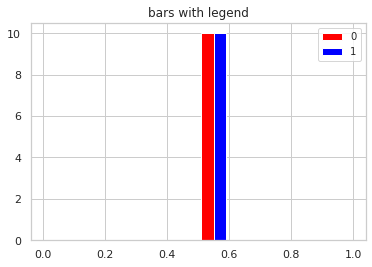

ensemble: auc_score: 0.5


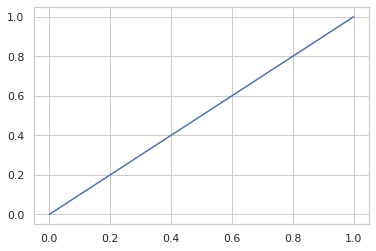

[[6 0]
 [1 0]]


In [15]:
feats = basic_feats
dicts = {}
anova_test_dicts = {}
# basic_feats = normalised_basic_feats
for model, df in dfs_ukb.items():
#     
#     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
    df = df.fillna(0)
    print(model)
    if 'UKB' not in model:
#         print('dataset cannot be processed!')
        continue

        
    dicts[model] = {}
    k_mod = 'TEST' + model[3:]
    if 'dataset' in model:
        k_mod = 'dataset_KORA_processed'
    print(k_mod)
    target_col = 'diabetes_status'

#     Equation 1 process
#     p_values, statsmodel, y_yp = discrete_group_feature_stats(basic_feats, df, target_col, ['sex'], True)
#     auc_score, f1_score = auc_roc(y_yp, f'{model}_csv_feats')
    dicts[model][target_col] = {} # p_values
#     dicts[model][target_col]['auc'] = auc_score
#     dicts[model][target_col]['f1'] = f1_score
    dicts, _ = aggregate_model_outputs(df, target_col, basic_feats, dicts, model, target_col, global_kora_models[k_mod]['normal'])
    
#     Equation 2 process
    for organ in ['liver']:
        feats = basic_feats + [ f'seg_{organ}']
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_seg')
        dicts[model][target_col+f'_{organ}_with_seg_volumes'] = {} # p_values
#         dicts[model][target_col+f'_{organ}_with_seg_volumes']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_with_seg_volumes']['f1'] = f1_score
        dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_with_seg_volumes', global_kora_models[k_mod][f'{organ}_seg'])

        if 'dataset' in model:
            continue
            
        #     Equation 3 process
        feats = basic_feats + [ f'seg_{organ}', f'iou_{organ}']
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_iou')
        dicts[model][target_col+f'_with_{organ}_seg_and_iou'] = {} # p_values
#         dicts[model][target_col+f'_with_{organ}_seg_and_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_with_{organ}_seg_and_iou']['f1'] = f1_score
        dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model,target_col+f'_with_{organ}_seg_and_iou', global_kora_models[k_mod][f'{organ}_seg_iou'])
    #     global_kora_models[model][f'{organ}_seg_iou'] = statsmodel
    
     #     Equation 3.2 process
        feats = basic_feats + [ f'seg_{organ}', f'cvinv']
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_iou')
        dicts[model][target_col+f'_with_{organ}_seg_and_cvinv'] = {} # p_values
#         dicts[model][target_col+f'_with_{organ}_seg_and_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_with_{organ}_seg_and_iou']['f1'] = f1_score
        dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model,target_col+f'_with_{organ}_seg_and_cvinv', global_kora_models[k_mod][f'{organ}_seg_cvinv'])
    #     global_kora_models[model][f'{organ}_seg_iou'] = statsmodel
    
    
    #     Equation 3.1 process
        feats = basic_feats + [f'seg_{organ}', f'iou_dot_seg_{organ}']
#         p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_with_seg_dot_iou')
        dicts[model][target_col+f'_with_{organ}_seg_dot_iou'] = {} # p_values
#         dicts[model][target_col+f'_with_{organ}_seg_dot_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_with_{organ}_seg_dot_iou']['f1'] = f1_score
        dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_with_{organ}_seg_dot_iou', global_kora_models[k_mod][f'{organ}_seg_dot_iou'])
    #     global_kora_models[model][f'{organ}_seg_dot_iou'] = statsmodel


        #     Equation 4.0 process
        feats = basic_feats + [ f'seg_{organ}']
#         p_values, statsmodel, y_yp = discrete_weighted_group_feats(df, target_col, feats, f'iou_{organ}')
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_csv_feats')
        dicts[model][target_col+f'_{organ}_seg_reg_iou'] = {} # p_values
#         dicts[model][target_col+f'_{organ}_seg_reg_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_seg_reg_iou']['f1'] = f1_score
        dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_seg_reg_iou', global_kora_models[k_mod][f'{organ}_seg_reg_iou'], f'iou_{organ}')
    
     #     Equation 4.0 process
        feats = basic_feats + [ f'seg_{organ}']
#         p_values, statsmodel, y_yp = discrete_weighted_group_feats(df, target_col, feats, f'iou_{organ}')
#         auc_score, f1_score = auc_roc(y_yp, f'{model}_{organ}_csv_feats')
        dicts[model][target_col+f'_{organ}_seg_reg_cvinv'] = {} # p_values
#         dicts[model][target_col+f'_{organ}_seg_reg_iou']['auc'] = auc_score
#         dicts[model][target_col+f'_{organ}_seg_reg_iou']['f1'] = f1_score
        dicts, _ = aggregate_model_outputs(df, target_col, feats, dicts, model, target_col+f'_{organ}_seg_reg_cvinv', global_kora_models[k_mod][f'{organ}_seg_reg_cvinv'], f'cvinv')


p_value_df = df_from_nested_dicts(dicts).T
# p_value_df_styler = highlight_significance(p_value_df, 0.05)
# p_value_df_styler

In [16]:
p_value_df[['v_auc']]

,,,v_auc
UKB_full_bayesian_0dot01_diabetes_status,diabetes_status,0,0.589604
UKB_full_bayesian_0dot01_diabetes_status_liver_with_seg_volumes,diabetes_status_liver_with_seg_volumes,0,0.500000
UKB_full_bayesian_0dot01_diabetes_status_with_liver_seg_and_iou,diabetes_status_with_liver_seg_and_iou,0,0.500000
UKB_full_bayesian_0dot01_diabetes_status_with_liver_seg_and_cvinv,diabetes_status_with_liver_seg_and_cvinv,0,0.500000
UKB_full_bayesian_0dot01_diabetes_status_with_liver_seg_dot_iou,diabetes_status_with_liver_seg_dot_iou,0,0.500000
UKB_full_bayesian_0dot01_diabetes_status_liver_seg_reg_iou,diabetes_status_liver_seg_reg_iou,0,0.623456
UKB_full_bayesian_0dot01_diabetes_status_liver_seg_reg_cvinv,diabetes_status_liver_seg_reg_cvinv,0,0.681086
UKB_MC_dropout_quicknat_diabetes_status,diabetes_status,0,0.589604
UKB_MC_dropout_quicknat_diabetes_status_liver_with_seg_volumes,diabetes_status_liver_with_seg_volumes,0,0.500000
UKB_MC_dropout_quicknat_diabetes_status_with_liver_seg_and_iou,diabetes_status_with_liver_seg_and_iou,0,0.500000


# Regression

In [17]:
# feats = basic_feats
# dicts = {}
# anova_test_dicts = {}
# for model, df in dfs.items():
# #     
# #     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
# #     df = df.fillna(0)

        
#     dicts[model] = {}
#     target_cols = ['seg_spleen_normalised', 'seg_liver_normalised']
#     for target_col in target_cols:
# #     #     Equation 1 process
# #         feats_string = make_feature_string(basic_feats, ['sex', 'diabetes_status'])
# #         p_values, statsmodel = normal_group_fit(df, target_col, feats_string)
# #         dicts[model][target_col] = p_values

#     #     Equation 2 process
#         feats = basic_feats + ['diabetes_status']
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel, y_yp = normal_group_fit(df, target_col, feats_string)
#         regression_plot(y_yp, f'{model}_{target_col}_csv-feats')
#         dicts[model][target_col+'_with_csv_feats'] = p_values

#         if 'dataset' in model:
# #             print('dataset cannot be processed!')
#             continue
    
#     #     Equation 3 process
#         if target_col == 'seg_spleen_normalised':
#             iou_feat = ['iou_spleen']
#         else:
#             iou_feat = ['iou_liver']
#         feats = basic_feats + [ 'diabetes_status'] + iou_feat
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel, y_yp = normal_group_fit(df, target_col, feats_string)
#         regression_plot(y_yp, f'{model}_{target_col}_seg_iou')
#         dicts[model][target_col+'_with_seg_and_iou'] = p_values

#     #     Equation 4 process
#         feats = basic_feats + [ 'diabetes_status']
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel, y_yp = weighted_group_feats(df, target_col, feats_string, iou_feat[0])
#         regression_plot(y_yp, f'{model}_{target_col}_seg_reg_iou')
#         dicts[model][target_col+'_with_regularised_seg_volumes'] = p_values

# p_value_df = df_from_nested_dicts(dicts).T
# p_value_df.to_csv('to_seg.csv')
# p_value_df_styler = highlight_significance(p_value_df, 0.05)
# p_value_df_styler

In [18]:
# p_value_df_styler = highlight_significance(p_value_df[['C(diabetes_status, Treatment)[T.1]', 'psuedo_r2']], 0.05)
# p_value_df_styler

In [19]:
# feats = basic_feats
# dicts = {}
# anova_test_dicts = {}
# for model, df in dfs_ukb.items():
# #     
# #     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
# #     df = df.fillna(0)

    

#     if 'UKB' not in model:
# #         print('dataset cannot be processed!')
#         continue
        
#     dicts[model] = {}
#     target_cols = ['seg_spleen_normalised', 'seg_liver_normalised']
#     for target_col in target_cols:
#     #     Equation 1 process
#         feats = basic_feats + ['diabetes_status']
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel, y_yp = normal_group_fit(df, target_col, feats_string)
#         regression_plot(y_yp, f'{model}_{target_col}')
#         dicts[model][target_col] = p_values

# #     #     Equation 2 process
# #         feats = basic_feats + ['diabetes_status']
# #         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
# #         p_values, statsmodel = normal_group_fit(df, target_col, feats_string)
# #         dicts[model][target_col+'_with_seg_volumes'] = p_values

#     #     Equation 3 process
#         if 'dataset' in model:
#             print('dataset cannot be processed!')
#             continue
#         if target_col == 'seg_spleen_normalised':
#             iou_feat = ['iou_spleen']
#         else:
#             iou_feat = ['iou_liver']
#         feats = basic_feats + [ 'diabetes_status'] + iou_feat
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel, y_yp = normal_group_fit(df, target_col, feats_string)
#         regression_plot(y_yp, f'{model}_{target_col}_seg_iou')
#         dicts[model][target_col+'_with_iou'] = p_values

#     #     Equation 4 process
#         feats = basic_feats + [ 'diabetes_status']
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel, y_yp = weighted_group_feats(df, target_col, feats_string, iou_feat[0])
#         regression_plot(y_yp, f'{model}_{target_col}_seg_reg_iou')
#         dicts[model][target_col+'_with_regularised_seg_volumes'] = p_values

# p_value_df = df_from_nested_dicts(dicts).T
# p_value_df.to_csv('to_seg.csv')
# p_value_df_styler = highlight_significance(p_value_df, 0.05)
# p_value_df_styler